In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing libraries :

In [0]:
!pip install matplotlib==3.1.0

In [8]:
import matplotlib
matplotlib.__version__

'3.1.0'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import preprocessing # KBinsDiscretizer
from sklearn import metrics
from joblib import parallel_backend
import scipy.stats as st
import xgboost as xgb
import lightgbm as lgb
from prettytable import PrettyTable

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

### Util Functions :

In [0]:
def auc_plot(c, tr, cv, param):
  plt.figure(figsize=(20, 6))
  plt.plot(c, tr, label='Train AUC')
  plt.plot(c, cv, label='CV AUC')
  plt.scatter(c, tr, label='Train AUC points')
  plt.scatter(c, cv, label='CV AUC points')
  plt.legend()
  plt.xlabel("{} : hyperparameter".format(param))
  plt.ylabel("AUC")
  plt.title("AUC plots for Train vs CV")
  plt.grid()
  plt.show()

def roc_plot(tr_fpr, tr_tpr, te_fpr, te_tpr):
  plt.plot(tr_fpr, tr_tpr, label="Train AUC = {}".format(metrics.auc(tr_fpr, tr_tpr)))
  plt.plot(te_fpr, te_tpr, label="Test AUC = {}".format(metrics.auc(te_fpr, te_tpr)))
  plt.legend()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.title("ROC Curve")
  plt.grid()
  plt.show()

def plotTrainVsCV_AUC(search, subplots, figsize, idx, cols):
  # Print seaborn heatmaps in subplots: https://stackoverflow.com/a/42712772/9079093
  figure, axes = plt.subplots(*subplots, figsize=figsize)
  # Using grid search parameters for heatmap : https://stackoverflow.com/a/48792210/9079093
  # Print values in seaborn heatmap without scientific notation: https://stackoverflow.com/a/29648332/9079093
  g1 = sns.heatmap(pd.pivot_table(pd.DataFrame(search.cv_results_),values='mean_train_score', index=idx, columns=cols),\
                   annot=True, annot_kws={"size": 13},cmap='Oranges', fmt='.2g', ax=axes[0], xticklabels=True, yticklabels=True)
  g1.set_title('Train AUC Heat Map plot')
  g1.set_ylabel(idx)
  g1.set_xlabel(cols)
  
  g2 = sns.heatmap(pd.pivot_table(pd.DataFrame(search.cv_results_),values='mean_test_score', index=idx, columns=cols),\
                   annot=True, annot_kws={"size": 13},cmap=None, fmt='.2g', ax=axes[1], xticklabels=True, yticklabels=True)
  g2.set_title('CV AUC Heat Map plot')
  g2.set_ylabel(idx)
  g2.set_xlabel(cols)

  plt.subplots_adjust(hspace=.3)
  plt.show()

def predict(proba, threshold, fpr, tpr, dtyp):
  t = threshold[np.argmax(tpr*(1-fpr))]
  # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
  print("The maximum value of {} tpr*(1-fpr) is {} for threshold {}".format(dtyp, max(tpr*(1-fpr)), np.round(t,3)),'\n')
  
  predictions = []
  for i in proba:
    if i>=t:
      predictions.append(1)
    else:
      predictions.append(0)
  
  return predictions

def printConfusionMatrix(y_tr, y_te, y_tr_pred, y_te_pred, tr_thresh, te_thresh, tr_fpr, tr_tpr, te_fpr, te_tpr):
  # Print seaborn heatmaps in subplots: https://stackoverflow.com/a/42712772/9079093
  figure, axes = plt.subplots(1,2, figsize=(15,5))
  # Print values in seaborn heatmap without scientific notation: https://stackoverflow.com/a/29648332/9079093
  g1 = sns.heatmap(metrics.confusion_matrix(y_tr, predict(y_tr_pred, tr_thresh, tr_fpr, tr_tpr, 'Train')),\
                   annot=True, annot_kws={"size": 16}, cmap='Oranges', fmt='g', ax=axes[0])
  g1.set_title('Train confusion matrix')
  g1.set_xlabel('Predicted Value')
  g1.set_ylabel('Actual Value')

  g2 = sns.heatmap(metrics.confusion_matrix(y_te, predict(y_te_pred, te_thresh, te_fpr, te_tpr, 'Test')),\
                   annot=True, annot_kws={"size": 16}, cmap='Purples', fmt='g', ax=axes[1])
  g2.set_title('Test confusion matrix')
  g2.set_xlabel('Predicted Value')
  g2.set_ylabel('Actual Value')

  plt.subplots_adjust(top=.9, wspace=.5, hspace=.5)
  plt.show()

### Reading the Data :

In [5]:
df_train = pd.read_csv('drive/My Drive/CoLab/CustomerTransactionPrediction/train.csv')
df_train.head()

ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

In [0]:
df_test = pd.read_csv('drive/My Drive/CoLab/CustomerTransactionPrediction/test.csv')
df_test.head()

### High level statistics:

In [0]:
print('Total Datapoints:',df_train.shape[0],\
      '\nTotal Features:',df_train.shape[1],'\n')

print('Some of the Features:')
for idx, col in enumerate(df_train.columns[1::20]):
    print(idx+1,':',col)

Total Datapoints: 200000 
Total Features: 202 

Some of the Features:
1 : target
2 : var_19
3 : var_39
4 : var_59
5 : var_79
6 : var_99
7 : var_119
8 : var_139
9 : var_159
10 : var_179
11 : var_199


In [0]:
print('Number of classes:', df_train.target.unique().size,'\n')

print('DataPoints per class:')
print(df_train.target.value_counts())

Number of classes: 2 

DataPoints per class:
0    179902
1     20098
Name: target, dtype: int64


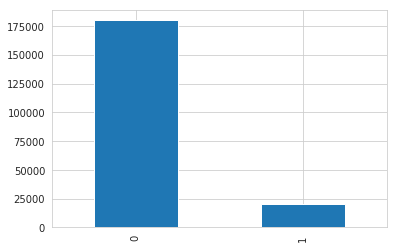

In [0]:
df_train['target'].value_counts().plot.bar()
plt.show()

In [0]:
if not (df_train.isnull().sum() > 0).any():
  print('No missing Values in the Training Data.')
else:
  print('Missing value features of Training Data :')
  print(df_train.columns[ df_train.isnull().sum() > 0 ])

No missing Values in the Training Data.


In [0]:
if not (df_test.isnull().sum() > 0).any():
  print('No missing Values in the Test Data.')
else:
  print('Missing value features of Test Data :')
  print(df_test.columns[ df_test.isnull().sum() > 0 ])

No missing Values in the Test Data.


In [0]:
df_train['target'].value_counts()/df_train.shape[0]*100.

0    89.951
1    10.049
Name: target, dtype: float64

* Based on the # data points per class we can observe that it's a highly imbalanced dataset.
  
  * Class_1 : 10%
  * Class_0 : 90% 

### EDA

**Objective :**

To identify if a customer will make a specific transaction or not in the future, irrespective of the amount of money transacted. The data provided here has the same structure as the real data we have available to solve this problem.

In [0]:
# Let's consider some of the features for the EDA part as there are 200 features and each is numeric.

eda_features = df_train.columns[2::20]
eda_features

Index(['var_0', 'var_20', 'var_40', 'var_60', 'var_80', 'var_100', 'var_120',
       'var_140', 'var_160', 'var_180'],
      dtype='object')

In [0]:
# Since all the required features are numeric we are excluding the non-numeric features and the target which is to be predicted.

df_train[df.columns.difference(['target'])].describe(exclude=['object'])

var_0          var_1  ...         var_98         var_99
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean       10.679914      -1.627622  ...       1.752012      -0.746296
std         3.040051       4.050044  ...       0.715836       1.862550
min         0.408400     -15.043400  ...      -0.603500      -7.280600
25%         8.453850      -4.740025  ...       1.267675      -2.106200
50%        10.524750      -1.608050  ...       1.768300      -0.771300
75%        12.758200       1.358625  ...       2.260900       0.528500
max        20.315000      10.376800  ...       4.502800       5.076400

[8 rows x 200 columns]

In [0]:
df_test.describe()

var_0          var_1  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean       10.658737      -1.624244  ...      15.869184      -3.246342
std         3.036716       4.040509  ...       3.008717      10.398589
min         0.188700     -15.043400  ...       6.584000     -39.457800
25%         8.442975      -4.700125  ...      13.847275     -11.124000
50%        10.513800      -1.590500  ...      15.943400      -2.725950
75%        12.739600       1.343400  ...      18.045200       4.935400
max        22.323400       9.385100  ...      26.538400      27.907400

[8 rows x 200 columns]

* The Mean and Spread for some of the features differ a lot between the train and test data.

In [0]:
sns.set_style('whitegrid')

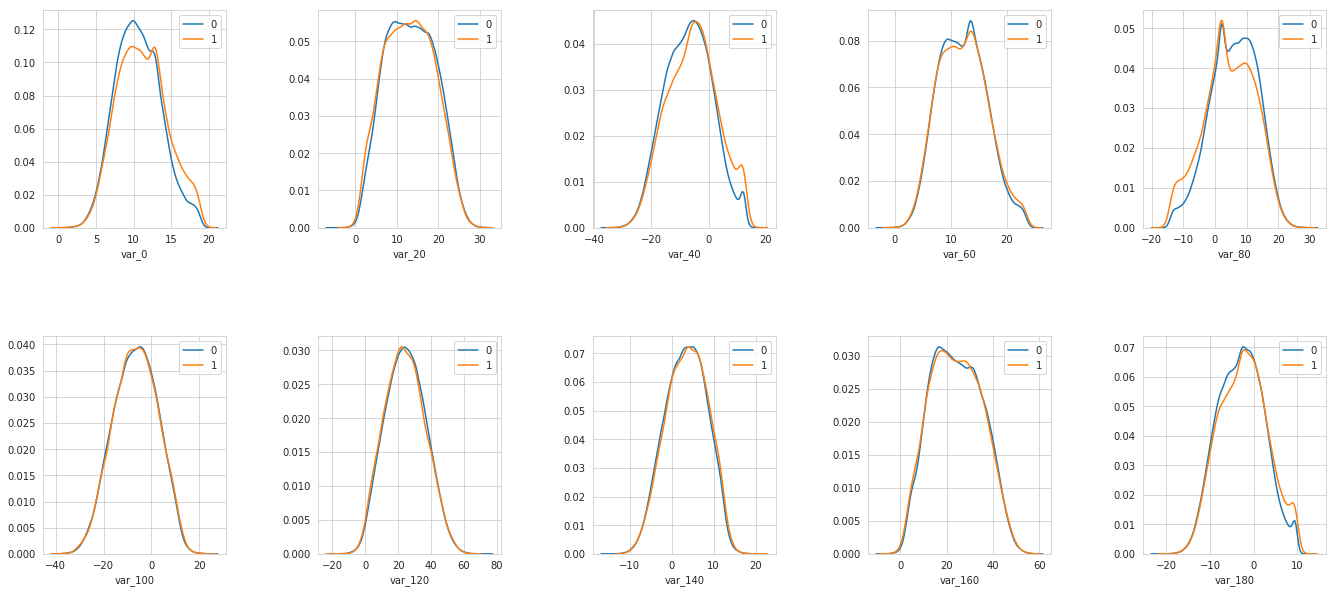

In [0]:
figure, axes = plt.subplots(2, 5, figsize=(23,10))
axes = axes.flatten()

df_train_0 = df_train[df_train.target == 0]
df_train_1 = df_train[df_train.target == 1]

for idx, feat in enumerate(eda_features):
  sns.kdeplot(df_train_0[feat], ax=axes[idx], label='0')
  sns.kdeplot(df_train_1[feat], ax=axes[idx], label='1').set_xlabel(feat)

plt.subplots_adjust(hspace=.5, wspace=.5)
plt.show()
plt.close()

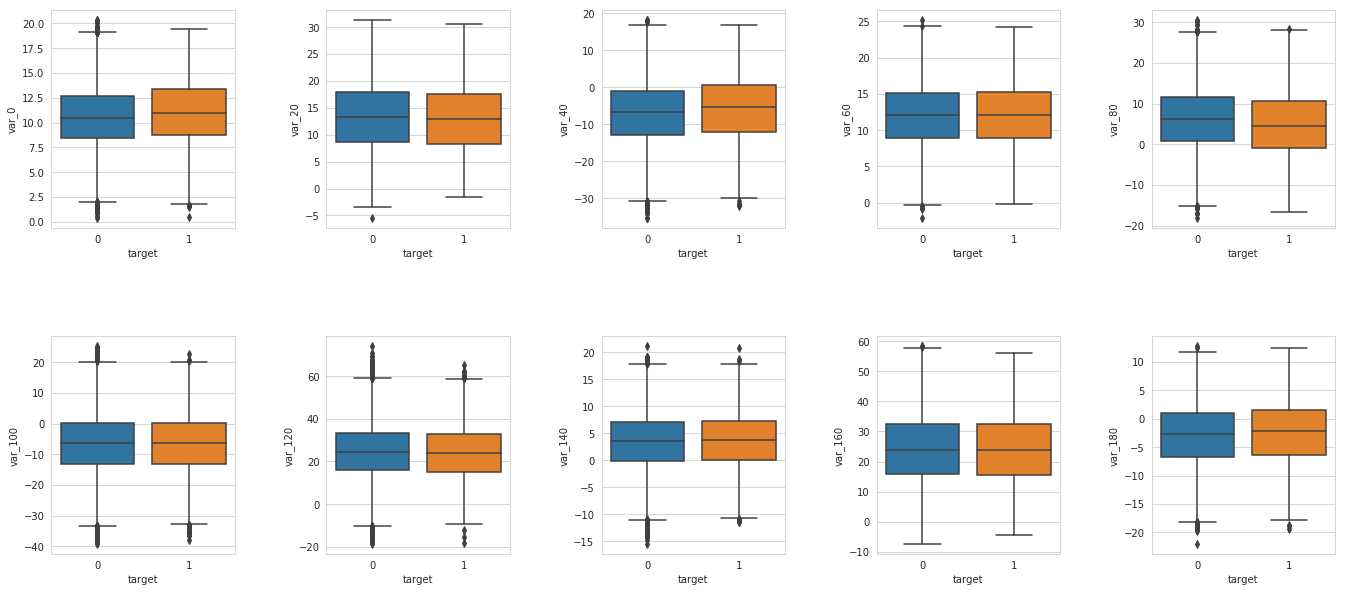

In [0]:
#Box Plots and whiskers
figure, axes = plt.subplots(2, 5, figsize=(23,10))
axes = axes.flatten()

for idx, col in enumerate(eda_features): 
    sns.boxplot(x='target', y=col, data=df_train, ax=axes[idx])

plt.subplots_adjust(wspace=.5, hspace=.5)
plt.show()
plt.close()

In [0]:
# # Violin Plots
# figure, axes = plt.subplots(2, 5, figsize=(23, 10))
# axes = axes.flatten()

# for idx, col in enumerate(eda_features): 
#     sns.violinplot(x='target', y=col, data=df_train, size=8, ax=axes[idx])
    
# plt.subplots_adjust(wspace=.5, hspace=.5)
# plt.show()
# plt.close()

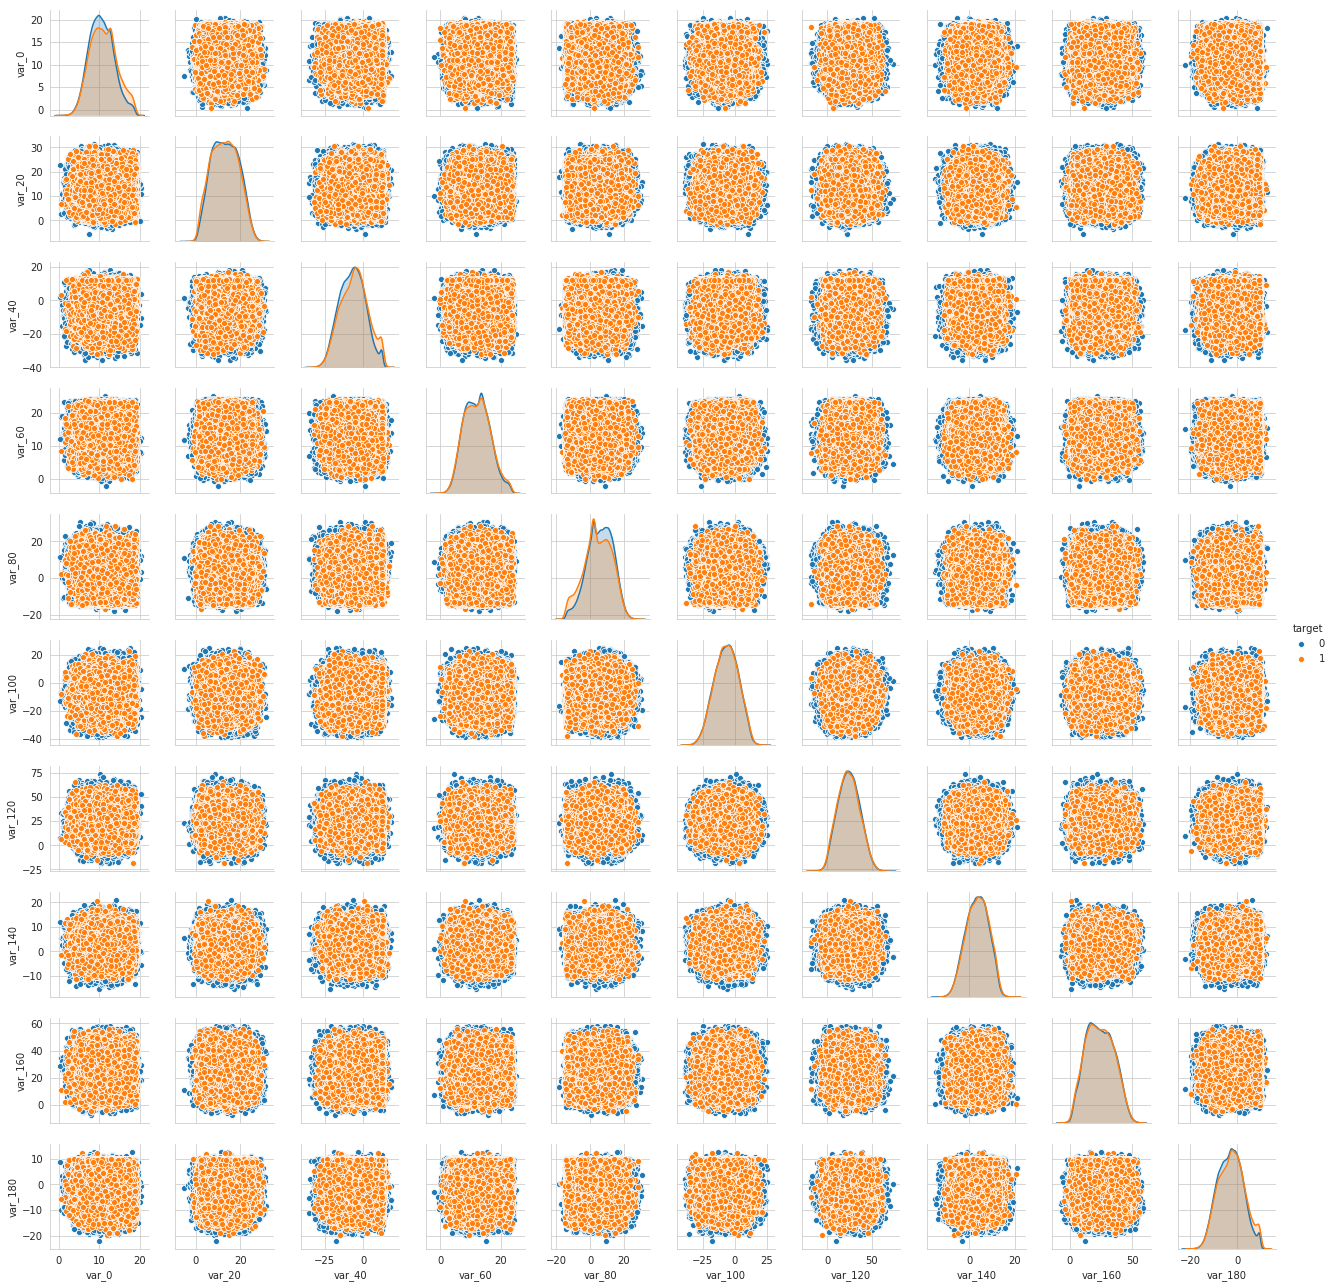

In [0]:
sns.pairplot(df_train[[*eda_features, 'target']], vars=eda_features ,hue='target', height=1.8)

plt.show()

* It's hard to seperate the classes using the linear models as we can see from the pair plots of the features, almost all of them overlap.
* Most of the features are Gaussian distributed except for some like var_0, var_20, var_40, var_60, var_80 and so on with some bumps on left or right of mean value.

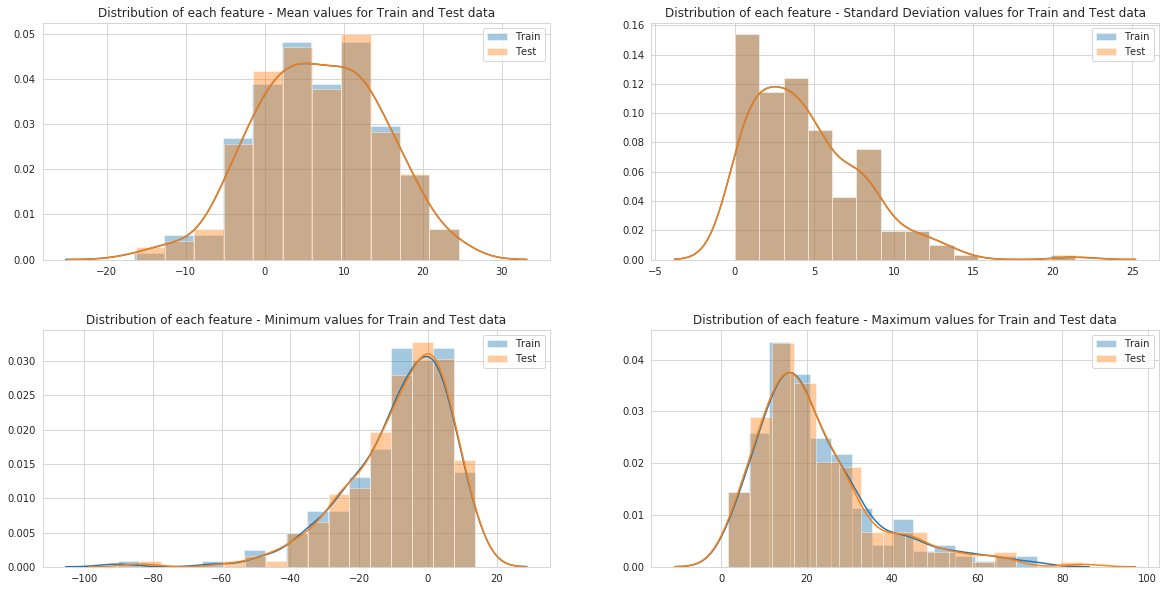

In [0]:
plots = ['Mean', 'Standard Deviation', 'Minimum', 'Maximum']
plot_funcs = [np.mean, np.std, np.min, np.max]

figure, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for idx, (stat, func) in enumerate(zip(plots, plot_funcs)):
  sns.distplot(df_train[df_train.columns.difference(['target', 'ID_code'])].apply(func), label='Train', ax=axes[idx])
  sns.distplot(df_test[df_train.columns.difference(['target', 'ID_code'])].apply(func), label='Test', ax=axes[idx])
  axes[idx].set_title('Distribution of each feature - {} values for Train and Test data'.format(stat))
  axes[idx].legend()

plt.subplots_adjust(hspace=.3)
plt.show()

* We can see that the train and test data come from almost similar distrubutions based on mean, standard devation, minimum and maximum values plots for each feature.

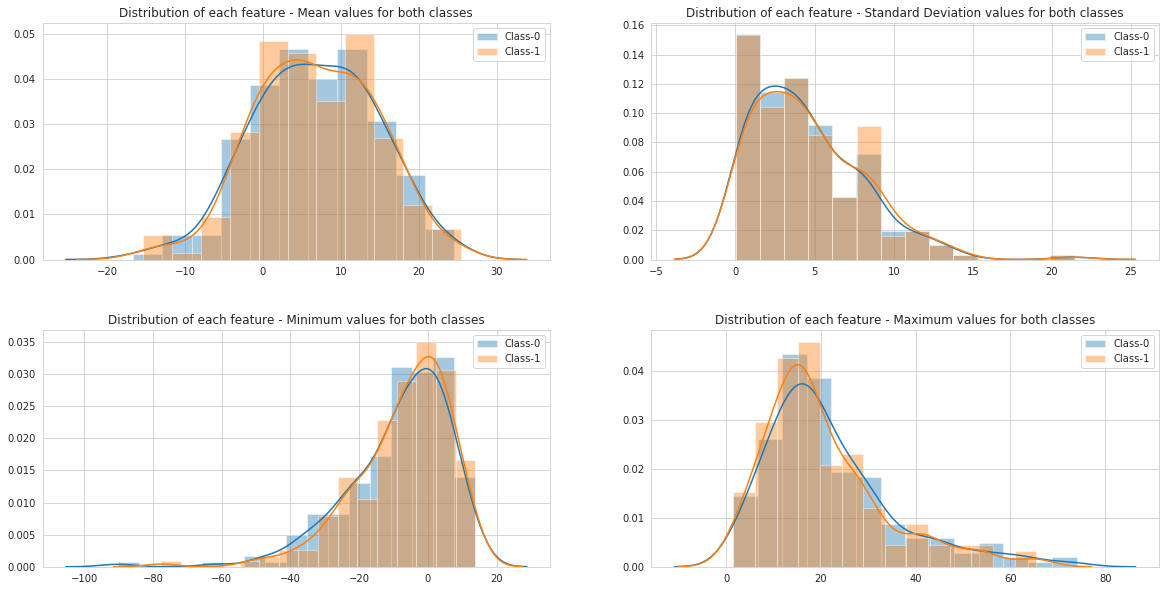

In [0]:
df_train_0 = df_train[df_train.target == 0][df_train.columns.difference(['target', 'ID_code'])]
df_train_1 = df_train[df_train.target == 1][df_train.columns.difference(['target', 'ID_code'])]

figure, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for idx, (stat, func) in enumerate(zip(plots, plot_funcs)):
  sns.distplot(df_train_0.apply(func), label='Class-0', ax=axes[idx])
  sns.distplot(df_train_1.apply(func), label='Class-1', ax=axes[idx])
  axes[idx].set_title('Distribution of each feature - {} values for both classes'.format(stat))
  axes[idx].legend()

plt.subplots_adjust(hspace=.3)
plt.show()

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

train_scaled =  StandardScaler().fit_transform(df_train[df_train.columns.difference(['target', 'ID_code'])])         

PCA_train = PCA(n_components=2).fit_transform(train_scaled)

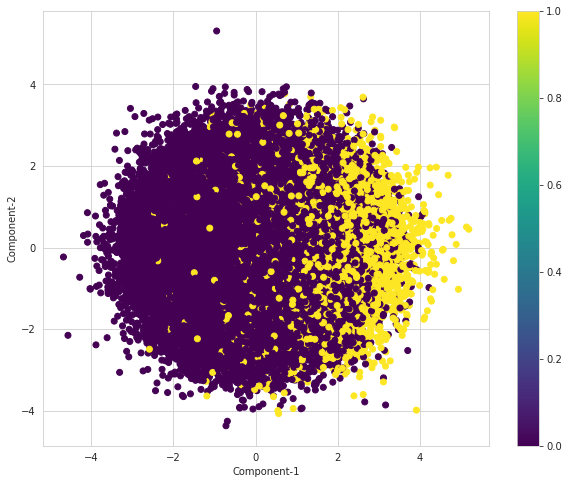

In [0]:
plt.figure(figsize=(10, 8))
plt.scatter(PCA_train[:, 0], PCA_train[:, 1], c=df_train.target.values, cmap='viridis',)

plt.xlabel('Component-1')
plt.ylabel('Component-2')
plt.colorbar()
plt.show()

* Even with the PCA the datapoints for both classes are almost overlapping that doesn't seems meaningful.

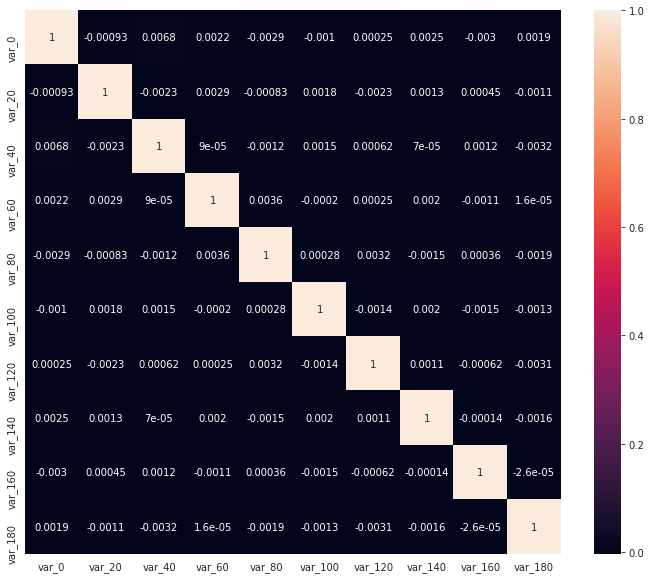

In [0]:
corr = df_train[eda_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True) # Correlation heatmap for choosen EDA features.
plt.show()

In [0]:
corr = df_train[df_train.columns.difference(['ID_code', 'target'])].corr()
corr = corr.abs().unstack().sort_values(ascending=False).reset_index()
corr = corr[corr['level_0'] != corr['level_1']]
corr.columns = ['Feature_1', 'Feature_2', 'Correlation']

corr.head(10) # Top 10 correlated features.

Feature_1 Feature_2  Correlation
200   var_139    var_26     0.009844
201    var_26   var_139     0.009844
202    var_53   var_148     0.009788
203   var_148    var_53     0.009788
204    var_81   var_165     0.009714
205   var_165    var_81     0.009714
206    var_81   var_174     0.009490
207   var_174    var_81     0.009490
208   var_183   var_189     0.009359
209   var_189   var_183     0.009359

In [0]:
corr.tail(10) # Least 10 correlated features.

Feature_1 Feature_2   Correlation
39990   var_100   var_177  3.116544e-07
39991   var_177   var_100  3.116544e-07
39992    var_27   var_144  1.772502e-07
39993   var_144    var_27  1.772502e-07
39994   var_126   var_109  1.313947e-07
39995   var_109   var_126  1.313947e-07
39996     var_6   var_173  5.942735e-08
39997   var_173     var_6  5.942735e-08
39998    var_75   var_191  2.703975e-08
39999   var_191    var_75  2.703975e-08

* The correlation between the pair of features is less which implies features are independent.

### Basic Features :

In [7]:
features = df_train.columns.difference(['ID_code', 'target'])

feat_names = ['mean', 'std', 'max', 'min', 'median']
feat_funcs = [np.mean, np.std, np.max, np.min, np.median]

for feat, func in tqdm(zip(feat_names, feat_funcs)):
  df_train[feat] = df_train[features].apply(func, axis=1)
  df_test[feat] = df_test[features].apply(func, axis=1)

5it [01:24, 17.99s/it]


In [0]:
df_train[feat_names].head()

mean        std      max      min   median
0  7.281591   9.308182  43.1127 -21.4494  6.77040
1  7.076818  10.310257  40.5632 -47.3797  7.22315
2  6.204483   8.731476  33.8820 -22.4038  5.89940
3  6.441160   9.570048  38.1015 -35.1659  6.70260
4  6.771155  11.258868  41.1037 -65.4863  6.94735

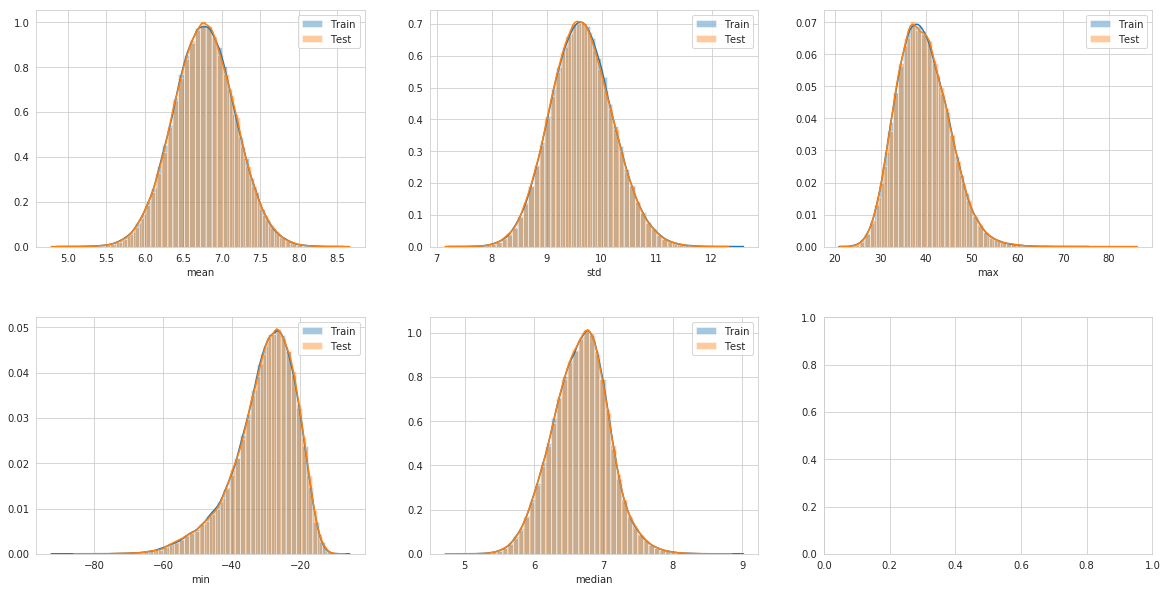

In [0]:
figure, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()

for idx, feat in enumerate(feat_names):
  sns.distplot(df_train[feat], ax=axes[idx], label='Train')
  sns.distplot(df_test[feat], ax=axes[idx], label='Test').set_xlabel(feat)
  axes[idx].legend()

plt.subplots_adjust(hspace=.3)
plt.show()

* The basic features seems to follow the gaussian distribution.

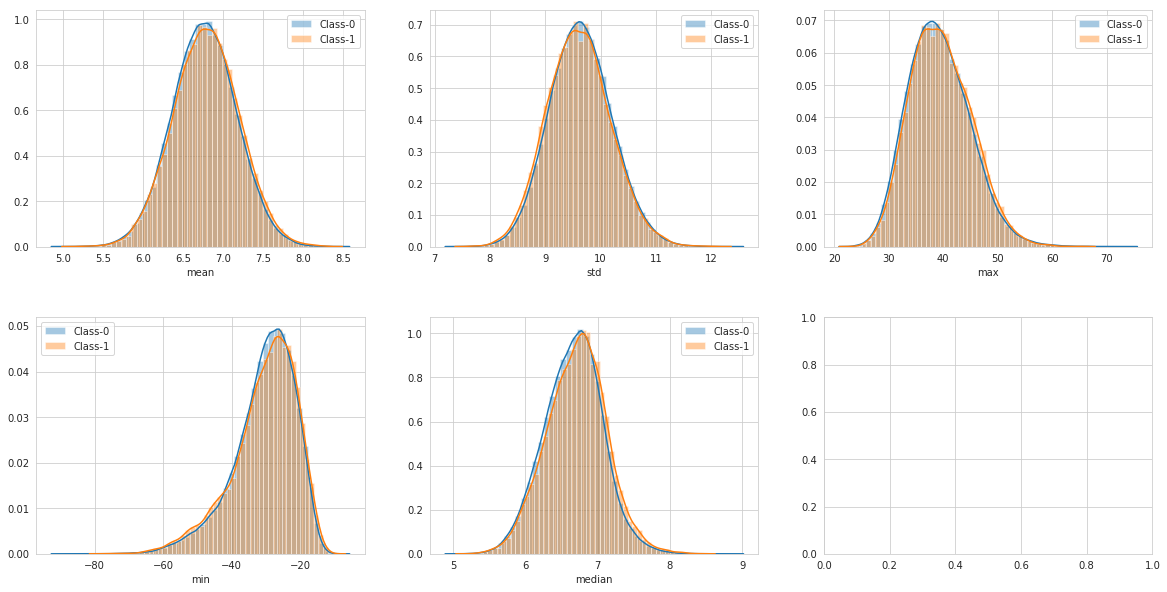

In [0]:
df_train_0 = df_train[df_train.target == 0][feat_names]
df_train_1 = df_train[df_train.target == 1][feat_names]

figure, axes = plt.subplots(2, 3, figsize=(20,10))
axes = axes.flatten()

for idx, feat in enumerate(feat_names):
  sns.distplot(df_train_0[feat], ax=axes[idx], label='Class-0')
  sns.distplot(df_train_1[feat], ax=axes[idx], label='Class-1').set_xlabel(feat)
  axes[idx].legend()

plt.subplots_adjust(hspace=.3)
plt.show()

### Modelling [1] - w/ basic features.

In [0]:
X = df_train[df_train.columns.difference(['ID_code', 'target'])]
y = df_train.target.values

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=.2, random_state=23, stratify=y)

pt_1 = PrettyTable()
pt_1.field_names = ['Model', 'Hyper Parameters', 'Train AUC', 'Test AUC']

#### Logistic Regression(LR) :

##### RandomSearch :

In [0]:
clf = linear_model.SGDClassifier('log', n_jobs=-1, class_weight='balanced')

params = dict(alpha=st.uniform(.00001, .01))
search = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True, cv=3)

In [0]:
with parallel_backend('threading'):
  search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] alpha=0.004119678779936287 ......................................
[CV] alpha=0.004119678779936287 ......................................


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[CV]  alpha=0.004119678779936287, score=(train=0.859, test=0.855), total=  22.7s
[CV] alpha=0.004119678779936287 ......................................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   22.9s


[CV]  alpha=0.004119678779936287, score=(train=0.857, test=0.855), total=  25.5s
[CV] alpha=0.0020817756520198705 .....................................
[CV]  alpha=0.004119678779936287, score=(train=0.859, test=0.853), total=  23.8s
[CV] alpha=0.0020817756520198705 .....................................
[CV]  alpha=0.0020817756520198705, score=(train=0.857, test=0.857), total=  37.7s
[CV] alpha=0.0020817756520198705 .....................................


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.1min


[CV]  alpha=0.0020817756520198705, score=(train=0.860, test=0.855), total=  34.2s
[CV] alpha=0.006450444852612077 ......................................
[CV]  alpha=0.0020817756520198705, score=(train=0.856, test=0.851), total=  30.3s
[CV] alpha=0.006450444852612077 ......................................
[CV]  alpha=0.006450444852612077, score=(train=0.857, test=0.854), total=  19.0s
[CV] alpha=0.006450444852612077 ......................................
[CV]  alpha=0.006450444852612077, score=(train=0.858, test=0.854), total=  19.8s
[CV] alpha=0.003828692542999418 ......................................
[CV]  alpha=0.006450444852612077, score=(train=0.860, test=0.856), total=  16.3s
[CV] alpha=0.003828692542999418 ......................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min


[CV]  alpha=0.003828692542999418, score=(train=0.857, test=0.853), total=  22.7s
[CV] alpha=0.003828692542999418 ......................................
[CV]  alpha=0.003828692542999418, score=(train=0.858, test=0.857), total=  26.4s
[CV] alpha=0.008794147947487162 ......................................
[CV]  alpha=0.008794147947487162, score=(train=0.857, test=0.855), total=  16.3s
[CV] alpha=0.008794147947487162 ......................................
[CV]  alpha=0.003828692542999418, score=(train=0.859, test=0.855), total=  24.1s
[CV] alpha=0.008794147947487162 ......................................
[CV]  alpha=0.008794147947487162, score=(train=0.860, test=0.857), total=  21.1s
[CV] alpha=0.001390875693309549 ......................................


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.0min


[CV]  alpha=0.008794147947487162, score=(train=0.859, test=0.853), total=  15.4s
[CV] alpha=0.001390875693309549 ......................................
[CV]  alpha=0.001390875693309549, score=(train=0.859, test=0.855), total=  33.9s
[CV] alpha=0.001390875693309549 ......................................
[CV]  alpha=0.001390875693309549, score=(train=0.856, test=0.854), total=  40.3s
[CV] alpha=0.006254124023839812 ......................................
[CV]  alpha=0.006254124023839812, score=(train=0.855, test=0.853), total=  17.0s
[CV] alpha=0.006254124023839812 ......................................
[CV]  alpha=0.001390875693309549, score=(train=0.857, test=0.853), total=  35.8s
[CV] alpha=0.006254124023839812 ......................................
[CV]  alpha=0.006254124023839812, score=(train=0.859, test=0.855), total=  20.1s
[CV] alpha=0.006669809715255771 ......................................
[CV]  alpha=0.006254124023839812, score=(train=0.859, test=0.855), total=  21.0s
[CV] al

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.5min


[CV]  alpha=0.006669809715255771, score=(train=0.859, test=0.857), total=  20.5s
[CV] alpha=0.006669809715255771 ......................................
[CV]  alpha=0.006669809715255771, score=(train=0.858, test=0.854), total=  16.6s
[CV] alpha=0.005264553242148463 ......................................
[CV]  alpha=0.006669809715255771, score=(train=0.859, test=0.853), total=  19.4s
[CV] alpha=0.005264553242148463 ......................................
[CV]  alpha=0.005264553242148463, score=(train=0.861, test=0.860), total=  22.0s
[CV] alpha=0.005264553242148463 ......................................
[CV]  alpha=0.005264553242148463, score=(train=0.860, test=0.856), total=  23.3s
[CV] alpha=0.005229899758690161 ......................................
[CV]  alpha=0.005264553242148463, score=(train=0.858, test=0.856), total=  17.2s
[CV] alpha=0.005229899758690161 ......................................
[CV]  alpha=0.005229899758690161, score=(train=0.857, test=0.854), total=  22.7s
[CV] al

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.0min finished


In [0]:
search.best_params_

{'alpha': 0.005264553242148463}

In [0]:
res = pd.DataFrame(search.cv_results_)

In [0]:
idxs = np.argsort(res.param_alpha.values.astype('float64'))

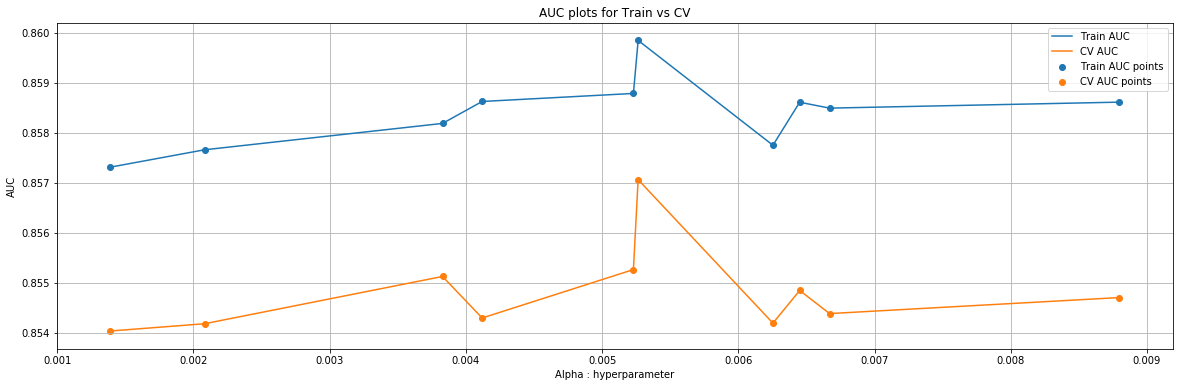

In [0]:
auc_plot(res.param_alpha.values.astype('float64')[idxs],\
         res.mean_train_score.values[idxs], res.mean_test_score.values[idxs], 'Alpha')

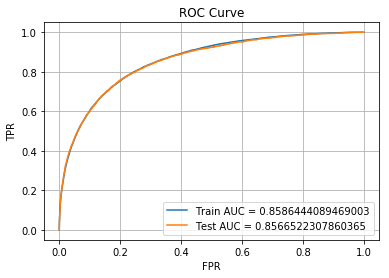

In [0]:
y_train_pred = search.best_estimator_.predict_proba(X_train)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

##### GridSearch :

In [0]:
clf = linear_model.SGDClassifier('log', n_jobs=-1, class_weight='balanced')

params = dict(alpha=[.00001, .0001, .001, .01, .1, 1, 10])
search = GridSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True, cv=3)

In [0]:
with parallel_backend('threading'):
  search.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] alpha=1e-05 .....................................................
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[CV] ..... alpha=1e-05, score=(train=0.841, test=0.838), total=  44.7s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   44.8s


[CV] ..... alpha=1e-05, score=(train=0.836, test=0.834), total=  48.6s
[CV] alpha=0.0001 ....................................................
[CV] .... alpha=0.0001, score=(train=0.845, test=0.845), total=  49.0s
[CV] alpha=0.0001 ....................................................
[CV] ..... alpha=1e-05, score=(train=0.836, test=0.834), total=  53.7s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min


[CV] .... alpha=0.0001, score=(train=0.835, test=0.835), total=  38.9s
[CV] alpha=0.001 .....................................................
[CV] .... alpha=0.0001, score=(train=0.843, test=0.840), total=  55.8s
[CV] alpha=0.001 .....................................................
[CV] ..... alpha=0.001, score=(train=0.851, test=0.848), total=  43.2s
[CV] alpha=0.001 .....................................................
[CV] ..... alpha=0.001, score=(train=0.858, test=0.854), total=  49.4s
[CV] alpha=0.01 ......................................................
[CV] ...... alpha=0.01, score=(train=0.858, test=0.856), total=  16.0s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.7min


[CV] ..... alpha=0.001, score=(train=0.850, test=0.849), total=  38.9s
[CV] alpha=0.01 ......................................................
[CV] ...... alpha=0.01, score=(train=0.859, test=0.854), total=  14.8s
[CV] alpha=0.1 .......................................................
[CV] ...... alpha=0.01, score=(train=0.860, test=0.857), total=  17.4s
[CV] alpha=0.1 .......................................................
[CV] ....... alpha=0.1, score=(train=0.848, test=0.846), total=   5.6s
[CV] alpha=0.1 .......................................................
[CV] ....... alpha=0.1, score=(train=0.848, test=0.846), total=   5.3s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.0min


[CV] ......... alpha=1, score=(train=0.830, test=0.829), total=   2.5s
[CV] alpha=1 .........................................................
[CV] ....... alpha=0.1, score=(train=0.849, test=0.843), total=   5.4s
[CV] alpha=1 .........................................................
[CV] ......... alpha=1, score=(train=0.831, test=0.827), total=   2.6s
[CV] alpha=10 ........................................................
[CV] ......... alpha=1, score=(train=0.831, test=0.827), total=   2.4s
[CV] alpha=10 ........................................................
[CV] ........ alpha=10, score=(train=0.796, test=0.795), total=   1.8s
[CV] alpha=10 ........................................................
[CV] ........ alpha=10, score=(train=0.796, test=0.791), total=   1.9s
[CV] ........ alpha=10, score=(train=0.797, test=0.796), total=   1.6s


[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  4.2min finished


In [0]:
search.best_params_

{'alpha': 0.01}

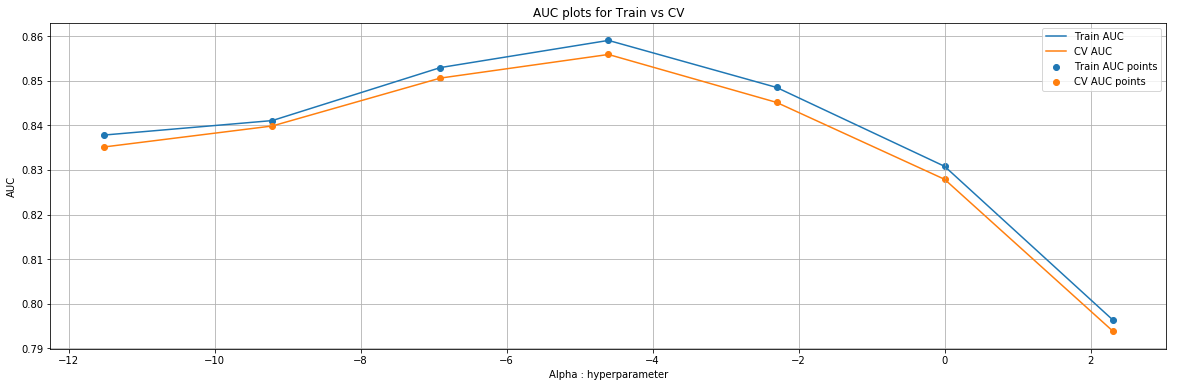

In [0]:
res = pd.DataFrame(search.cv_results_)

auc_plot(np.log(res.param_alpha.values.astype('float64')),\
         res.mean_train_score.values, res.mean_test_score.values, 'Alpha')

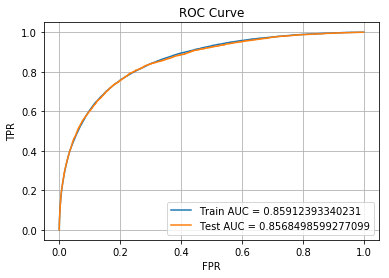

In [0]:
y_train_pred = search.best_estimator_.predict_proba(X_train)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

In [0]:
pt_1 = PrettyTable()
pt_1.field_names = ['Model', 'Hyper Paramters', 'Train AUC', 'Test AUC']

pt_1.add_row(['Logistic Regression', 'alpha = 0.01', np.round(.85912393340231, 3), np.round(.8568498599277099, 3)])

* The results were almost similar with simple SGD based Logisitc Regression with test **AUROC** of  **`".856"`**.

#### Random Forest

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
clf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, oob_score=True)

params = dict(max_depth=[5, 8, 10], n_estimators=[25, 50, 100], min_samples_split=[5, 10, 100])

search = GridSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True, cv=2)

In [0]:
with parallel_backend('threading'):
  search.fit(X_train, y_train)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] max_depth=5, min_samples_split=5, n_estimators=25 ...............[CV] max_depth=5, min_samples_split=5, n_estimators=25 ...............


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.



[CV]  max_depth=5, min_samples_split=5, n_estimators=25, score=(train=0.810, test=0.770), total= 1.0min
[CV]  max_depth=5, min_samples_split=5, n_estimators=25, score=(train=0.796, test=0.759), total= 1.0min


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=5, min_samples_split=5, n_estimators=25, score=(train=0.790, test=0.752), total= 1.0min
[CV] max_depth=5, min_samples_split=5, n_estimators=50 ...............


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min


[CV]  max_depth=5, min_samples_split=5, n_estimators=25, score=(train=0.802, test=0.760), total= 1.0min
[CV] max_depth=5, min_samples_split=5, n_estimators=50 ...............
[CV]  max_depth=5, min_samples_split=5, n_estimators=50, score=(train=0.821, test=0.781), total= 1.4min
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=50, score=(train=0.807, test=0.771), total= 1.4min
[CV] max_depth=5, min_samples_split=5, n_estimators=100 ..............


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.4min


[CV]  max_depth=15, min_samples_split=5, n_estimators=150, score=(train=1.000, test=0.774), total= 6.9min
[CV]  max_depth=15, min_samples_split=5, n_estimators=150, score=(train=1.000, test=0.770), total= 7.2min
[CV]  max_depth=5, min_samples_split=5, n_estimators=100, score=(train=0.834, test=0.794), total= 2.0min
[CV] max_depth=5, min_samples_split=10, n_estimators=25 ..............
[CV]  max_depth=5, min_samples_split=5, n_estimators=100, score=(train=0.824, test=0.783), total= 2.0min
[CV] max_depth=5, min_samples_split=10, n_estimators=25 ..............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=5, min_samples_split=10, n_estimators=25, score=(train=0.798, test=0.759), total=  20.7s
[CV] max_depth=5, min_samples_split=10, n_estimators=50 ..............
[CV]  max_depth=5, min_samples_split=10, n_estimators=25, score=(train=0.811, test=0.773), total=  20.8s
[CV] max_depth=5, min_samples_split=10, n_estimators=50 ..............
[CV]  max_depth=5, min_samples_split=10, n_estimators=50, score=(train=0.814, test=0.773), total=  40.6s
[CV] max_depth=5, min_samples_split=10, n_estimators=100 .............


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.5min


[CV]  max_depth=5, min_samples_split=10, n_estimators=50, score=(train=0.821, test=0.781), total=  40.7s
[CV] max_depth=5, min_samples_split=10, n_estimators=100 .............
[CV]  max_depth=5, min_samples_split=10, n_estimators=100, score=(train=0.830, test=0.790), total= 1.3min
[CV] max_depth=5, min_samples_split=100, n_estimators=25 .............
[CV]  max_depth=5, min_samples_split=10, n_estimators=100, score=(train=0.825, test=0.786), total= 1.3min
[CV] max_depth=5, min_samples_split=100, n_estimators=25 .............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=5, min_samples_split=100, n_estimators=25, score=(train=0.795, test=0.760), total=  20.2s
[CV] max_depth=5, min_samples_split=100, n_estimators=50 .............
[CV]  max_depth=5, min_samples_split=100, n_estimators=25, score=(train=0.796, test=0.760), total=  20.2s
[CV] max_depth=5, min_samples_split=100, n_estimators=50 .............


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.2min


[CV]  max_depth=5, min_samples_split=100, n_estimators=50, score=(train=0.814, test=0.780), total=  40.2s
[CV] max_depth=5, min_samples_split=100, n_estimators=100 ............
[CV]  max_depth=5, min_samples_split=100, n_estimators=50, score=(train=0.819, test=0.780), total=  40.3s
[CV] max_depth=5, min_samples_split=100, n_estimators=100 ............
[CV]  max_depth=5, min_samples_split=100, n_estimators=100, score=(train=0.822, test=0.785), total= 1.3min
[CV] max_depth=8, min_samples_split=5, n_estimators=25 ...............
[CV]  max_depth=5, min_samples_split=100, n_estimators=100, score=(train=0.826, test=0.787), total= 1.3min
[CV] max_depth=8, min_samples_split=5, n_estimators=25 ...............
[CV]  max_depth=8, min_samples_split=5, n_estimators=25, score=(train=0.886, test=0.758), total=  30.6s
[CV] max_depth=8, min_samples_split=5, n_estimators=50 ...............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=8, min_samples_split=5, n_estimators=25, score=(train=0.876, test=0.758), total=  30.8s
[CV] max_depth=8, min_samples_split=5, n_estimators=50 ...............
[CV]  max_depth=8, min_samples_split=5, n_estimators=50, score=(train=0.899, test=0.783), total= 1.0min
[CV] max_depth=8, min_samples_split=5, n_estimators=100 ..............


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 10.8min


[CV]  max_depth=8, min_samples_split=5, n_estimators=50, score=(train=0.898, test=0.786), total= 1.0min
[CV] max_depth=8, min_samples_split=5, n_estimators=100 ..............
[CV]  max_depth=8, min_samples_split=5, n_estimators=100, score=(train=0.909, test=0.796), total= 2.0min
[CV] max_depth=8, min_samples_split=10, n_estimators=25 ..............
[CV]  max_depth=8, min_samples_split=5, n_estimators=100, score=(train=0.910, test=0.796), total= 2.0min
[CV] max_depth=8, min_samples_split=10, n_estimators=25 ..............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=8, min_samples_split=10, n_estimators=25, score=(train=0.877, test=0.758), total=  30.5s
[CV] max_depth=8, min_samples_split=10, n_estimators=50 ..............
[CV]  max_depth=8, min_samples_split=10, n_estimators=25, score=(train=0.880, test=0.766), total=  30.8s
[CV] max_depth=8, min_samples_split=10, n_estimators=50 ..............
[CV]  max_depth=8, min_samples_split=10, n_estimators=50, score=(train=0.904, test=0.784), total= 1.0min
[CV] max_depth=8, min_samples_split=10, n_estimators=100 .............
[CV]  max_depth=8, min_samples_split=10, n_estimators=50, score=(train=0.903, test=0.786), total= 1.0min
[CV] max_depth=8, min_samples_split=10, n_estimators=100 .............


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 14.5min


[CV]  max_depth=8, min_samples_split=10, n_estimators=100, score=(train=0.908, test=0.796), total= 2.0min
[CV] max_depth=8, min_samples_split=100, n_estimators=25 .............
[CV]  max_depth=8, min_samples_split=10, n_estimators=100, score=(train=0.911, test=0.796), total= 2.1min
[CV] max_depth=8, min_samples_split=100, n_estimators=25 .............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=8, min_samples_split=100, n_estimators=25, score=(train=0.877, test=0.782), total=  29.6s
[CV] max_depth=8, min_samples_split=100, n_estimators=50 .............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=8, min_samples_split=100, n_estimators=25, score=(train=0.870, test=0.769), total=  30.9s
[CV] max_depth=8, min_samples_split=100, n_estimators=50 .............
[CV]  max_depth=8, min_samples_split=100, n_estimators=50, score=(train=0.892, test=0.796), total= 1.0min
[CV] max_depth=8, min_samples_split=100, n_estimators=100 ............
[CV]  max_depth=8, min_samples_split=100, n_estimators=50, score=(train=0.884, test=0.788), total= 1.0min
[CV] max_depth=8, min_samples_split=100, n_estimators=100 ............
[CV]  max_depth=8, min_samples_split=100, n_estimators=100, score=(train=0.896, test=0.804), total= 2.0min
[CV] max_depth=10, min_samples_split=5, n_estimators=25 ..............
[CV]  max_depth=8, min_samples_split=100, n_estimators=100, score=(train=0.899, test=0.805), total= 2.0min
[CV] max_depth=10, min_samples_split=5, n_estimators=25 ..............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=10, min_samples_split=5, n_estimators=25, score=(train=0.941, test=0.743), total=  34.7s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 20.6min


[CV]  max_depth=10, min_samples_split=5, n_estimators=25, score=(train=0.944, test=0.743), total=  36.8s
[CV] max_depth=10, min_samples_split=5, n_estimators=50 ..............
[CV]  max_depth=10, min_samples_split=5, n_estimators=50, score=(train=0.958, test=0.770), total= 1.2min
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=50, score=(train=0.961, test=0.776), total= 1.2min
[CV] max_depth=10, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=(train=0.969, test=0.792), total= 2.5min
[CV] max_depth=10, min_samples_split=10, n_estimators=25 .............
[CV]  max_depth=10, min_samples_split=5, n_estimators=100, score=(train=0.964, test=0.793), total= 2.5min
[CV] max_depth=10, min_samples_split=10, n_estimators=25 .............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=10, min_samples_split=10, n_estimators=25, score=(train=0.943, test=0.747), total=  34.8s
[CV] max_depth=10, min_samples_split=10, n_estimators=50 .............


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=10, min_samples_split=10, n_estimators=25, score=(train=0.938, test=0.744), total=  37.4s
[CV] max_depth=10, min_samples_split=10, n_estimators=50 .............
[CV]  max_depth=10, min_samples_split=10, n_estimators=50, score=(train=0.956, test=0.778), total= 1.2min
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=50, score=(train=0.952, test=0.773), total= 1.2min
[CV] max_depth=10, min_samples_split=10, n_estimators=100 ............


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 26.5min


[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=(train=0.968, test=0.792), total= 2.4min
[CV] max_depth=10, min_samples_split=100, n_estimators=25 ............
[CV]  max_depth=10, min_samples_split=10, n_estimators=100, score=(train=0.968, test=0.795), total= 2.5min
[CV] max_depth=10, min_samples_split=100, n_estimators=25 ............
[CV]  max_depth=10, min_samples_split=100, n_estimators=25, score=(train=0.917, test=0.775), total=  34.6s
[CV] max_depth=10, min_samples_split=100, n_estimators=50 ............
[CV]  max_depth=10, min_samples_split=100, n_estimators=25, score=(train=0.908, test=0.775), total=  36.9s
[CV] max_depth=10, min_samples_split=100, n_estimators=50 ............
[CV]  max_depth=10, min_samples_split=100, n_estimators=50, score=(train=0.934, test=0.798), total= 1.2min
[CV] max_depth=10, min_samples_split=100, n_estimators=100 ...........
[CV]  max_depth=10, min_samples_split=100, n_estimators=50, score=(train=0.933, test=0.796), total= 1.2min
[CV

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 33.1min finished


In [0]:
res = pd.DataFrame(search.cv_results_)

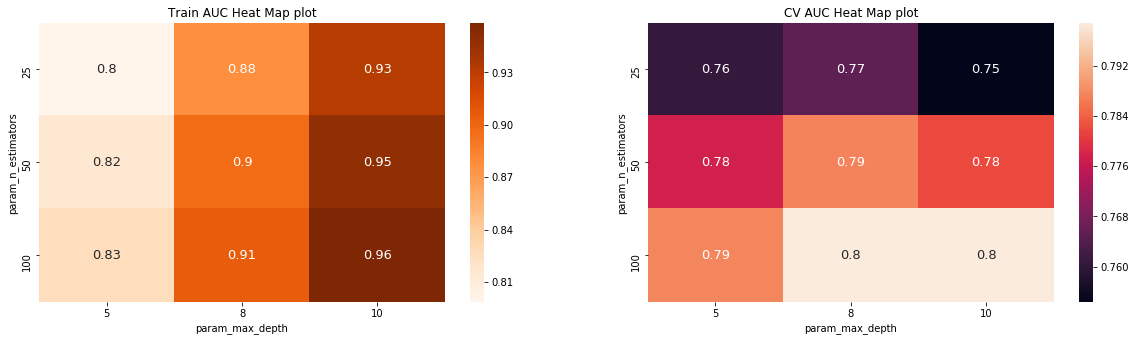

In [0]:
plotTrainVsCV_AUC(search, subplots=(1, 2), figsize=(20, 5) idx='param_n_estimators', cols='param_max_depth')

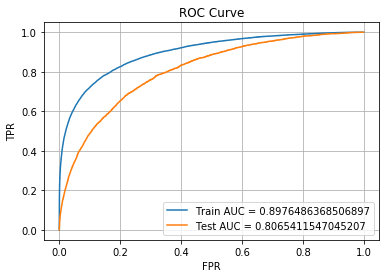

In [0]:
y_train_pred = search.best_estimator_.predict_proba(X_train)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

* Tried Decision Tree and Random Forest but didn't gave better results as both were completely over-fitting on training data even with the various hyper parameters.  

In [0]:
pt_1.add_row(['', '', '', ''])
pt_1.add_row(['Random Forest', 'Max_depth = 8, n_estimators = 100',\
              np.round(.8976486368506897, 3), np.round(.8065411547045207, 3)])

#### XGBOOST

In [0]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(3, 200),
    "max_depth": st.randint(3, 10),
    "learning_rate": st.uniform(0.001, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    "reg_lambda": st.uniform(0.001, 0.1),
    "min_child_weight": from_zero_positive,
}

search = RandomizedSearchCV(xgb.XGBClassifier(eval_metric='auc', objective='binary:logistic', n_jobs=-1, tree_method='auto'),\
                            params, scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True, cv=2)

In [0]:
with parallel_backend('multiprocessing'):
  search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 2 concurrent workers.


[CV] colsample_bytree=0.892207906442659, gamma=1.7488800353518186, learning_rate=0.06747751081039131, max_depth=8, min_child_weight=21.851606190465088, n_estimators=93, reg_lambda=0.08253053315245326, subsample=0.9226774110370277 
[CV] colsample_bytree=0.892207906442659, gamma=1.7488800353518186, learning_rate=0.06747751081039131, max_depth=8, min_child_weight=21.851606190465088, n_estimators=93, reg_lambda=0.08253053315245326, subsample=0.9226774110370277 
[CV]  colsample_bytree=0.892207906442659, gamma=1.7488800353518186, learning_rate=0.06747751081039131, max_depth=8, min_child_weight=21.851606190465088, n_estimators=93, reg_lambda=0.08253053315245326, subsample=0.9226774110370277, score=(train=0.954, test=0.849), total= 7.8min
[CV]  colsample_bytree=0.892207906442659, gamma=1.7488800353518186, learning_rate=0.06747751081039131, max_depth=8, min_child_weight=21.851606190465088, n_estimators=93, reg_lambda=0.08253053315245326, subsample=0.9226774110370277, score=(train=0.956, test=0.

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.8min


[CV]  colsample_bytree=0.8554388572158456, gamma=1.2808291901922786, learning_rate=0.06480135327008976, max_depth=4, min_child_weight=63.22383782769299, n_estimators=91, reg_lambda=0.016279529095083668, subsample=0.6932577829777565, score=(train=0.860, test=0.824), total= 3.3min
[CV] colsample_bytree=0.9644454614980406, gamma=6.075913532620509, learning_rate=0.002032830201545121, max_depth=7, min_child_weight=55.72368578803438, n_estimators=68, reg_lambda=0.0358647229261306, subsample=0.9921905942236565 
[CV]  colsample_bytree=0.8554388572158456, gamma=1.2808291901922786, learning_rate=0.06480135327008976, max_depth=4, min_child_weight=63.22383782769299, n_estimators=91, reg_lambda=0.016279529095083668, subsample=0.6932577829777565, score=(train=0.860, test=0.820), total= 3.3min
[CV] colsample_bytree=0.9644454614980406, gamma=6.075913532620509, learning_rate=0.002032830201545121, max_depth=7, min_child_weight=55.72368578803438, n_estimators=68, reg_lambda=0.0358647229261306, subsample=

[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 11.1min


[CV]  colsample_bytree=0.9644454614980406, gamma=6.075913532620509, learning_rate=0.002032830201545121, max_depth=7, min_child_weight=55.72368578803438, n_estimators=68, reg_lambda=0.0358647229261306, subsample=0.9921905942236565, score=(train=0.732, test=0.698), total= 5.2min
[CV] colsample_bytree=0.9552976445386667, gamma=8.070588074129297, learning_rate=0.03867883887926241, max_depth=4, min_child_weight=38.298202983871086, n_estimators=120, reg_lambda=0.03309635037246653, subsample=0.9746209401382341 
[CV]  colsample_bytree=0.9644454614980406, gamma=6.075913532620509, learning_rate=0.002032830201545121, max_depth=7, min_child_weight=55.72368578803438, n_estimators=68, reg_lambda=0.0358647229261306, subsample=0.9921905942236565, score=(train=0.732, test=0.697), total= 5.3min
[CV] colsample_bytree=0.9552976445386667, gamma=8.070588074129297, learning_rate=0.03867883887926241, max_depth=4, min_child_weight=38.298202983871086, n_estimators=120, reg_lambda=0.03309635037246653, subsample=

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 22.8min


[CV]  colsample_bytree=0.9760882562642434, gamma=7.33899070008214, learning_rate=0.07511994983852938, max_depth=6, min_child_weight=52.05549446335297, n_estimators=16, reg_lambda=0.016381614223396755, subsample=0.9846398442555937, score=(train=0.777, test=0.731), total= 1.1min
[CV] colsample_bytree=0.9392374918228288, gamma=1.2976168531850774, learning_rate=0.0033690080424075832, max_depth=9, min_child_weight=121.04345829562762, n_estimators=189, reg_lambda=0.0017891873407416261, subsample=0.8649567989813004 
[CV]  colsample_bytree=0.9392374918228288, gamma=1.2976168531850774, learning_rate=0.0033690080424075832, max_depth=9, min_child_weight=121.04345829562762, n_estimators=189, reg_lambda=0.0017891873407416261, subsample=0.8649567989813004, score=(train=0.795, test=0.748), total=16.8min
[CV] colsample_bytree=0.9905388970901187, gamma=0.9553491010166437, learning_rate=0.08297699202864298, max_depth=7, min_child_weight=33.349588022354965, n_estimators=39, reg_lambda=0.09579148177344904

[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 42.9min


[CV]  colsample_bytree=0.6822568644110761, gamma=0.21387817694568323, learning_rate=0.06766228327528674, max_depth=5, min_child_weight=17.747049596571745, n_estimators=42, reg_lambda=0.055513040244731464, subsample=0.9330200170360701, score=(train=0.833, test=0.779), total= 1.7min
[CV] colsample_bytree=0.9086723055091218, gamma=0.21216894437701028, learning_rate=0.07222791991688925, max_depth=9, min_child_weight=37.48636405680028, n_estimators=181, reg_lambda=0.014456759006000242, subsample=0.7045874614416053 
[CV]  colsample_bytree=0.6822568644110761, gamma=0.21387817694568323, learning_rate=0.06766228327528674, max_depth=5, min_child_weight=17.747049596571745, n_estimators=42, reg_lambda=0.055513040244731464, subsample=0.9330200170360701, score=(train=0.836, test=0.785), total= 1.7min
[CV] colsample_bytree=0.9086723055091218, gamma=0.21216894437701028, learning_rate=0.07222791991688925, max_depth=9, min_child_weight=37.48636405680028, n_estimators=181, reg_lambda=0.014456759006000242

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 68.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 68.4min finished


In [0]:
search.best_params_

{'colsample_bytree': 0.9086723055091218,
 'gamma': 0.21216894437701028,
 'learning_rate': 0.07222791991688925,
 'max_depth': 9,
 'min_child_weight': 37.48636405680028,
 'n_estimators': 181,
 'reg_lambda': 0.014456759006000242,
 'subsample': 0.7045874614416053}

In [0]:
xgb.plot_importance?

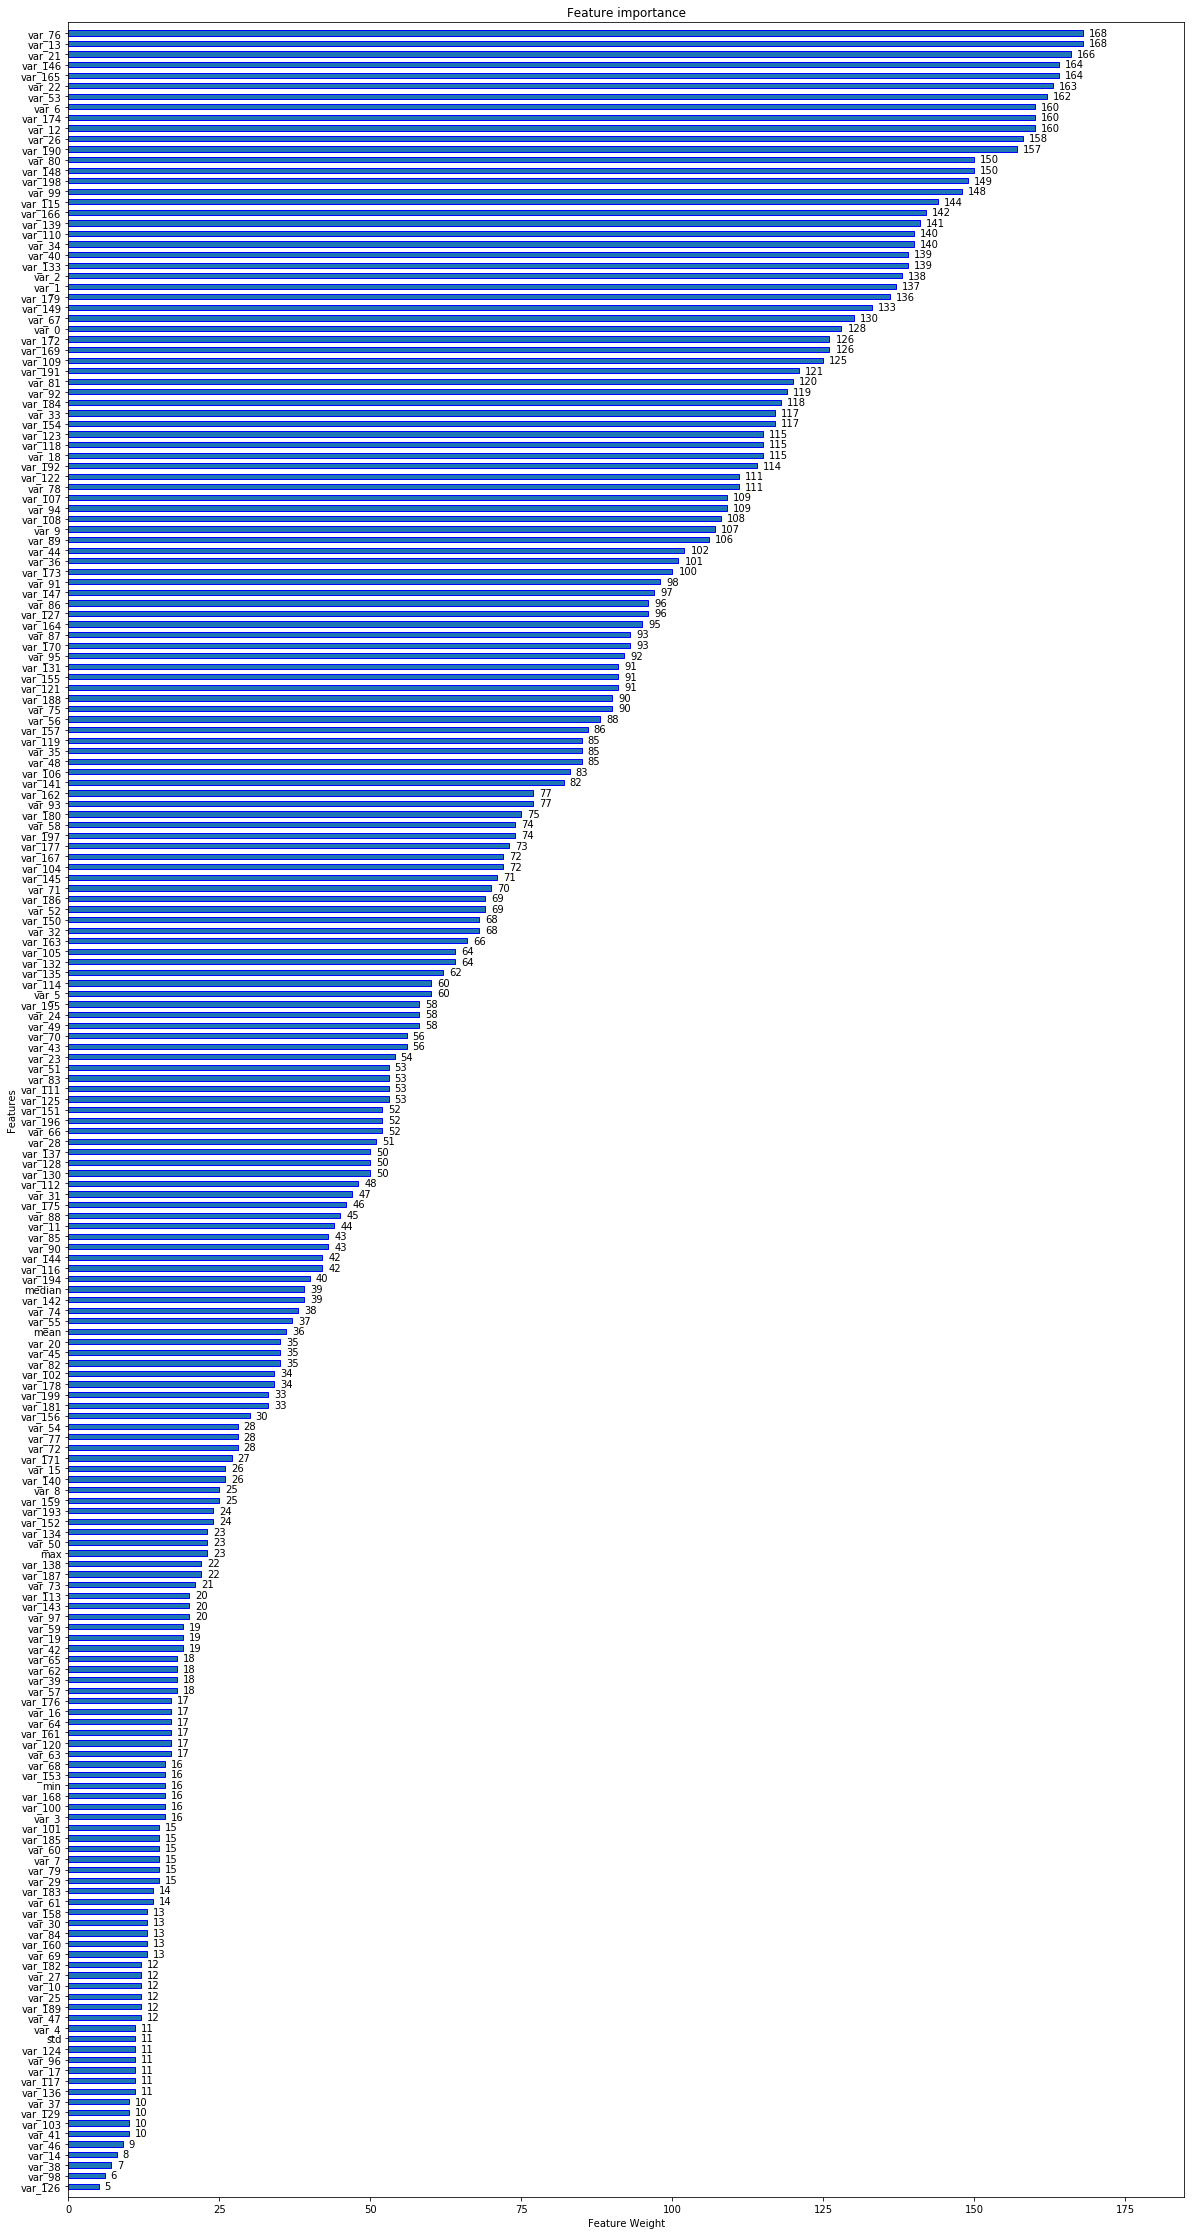

In [0]:
plt.figure(figsize=(20, 40))
xgb.plot_importance(search.best_estimator_, plt.gca(), grid=False, height=.4, edgecolor='blue', xlabel='Feature Weight')
plt.show()

In [0]:
res = pd.DataFrame(search.cv_results_)
res

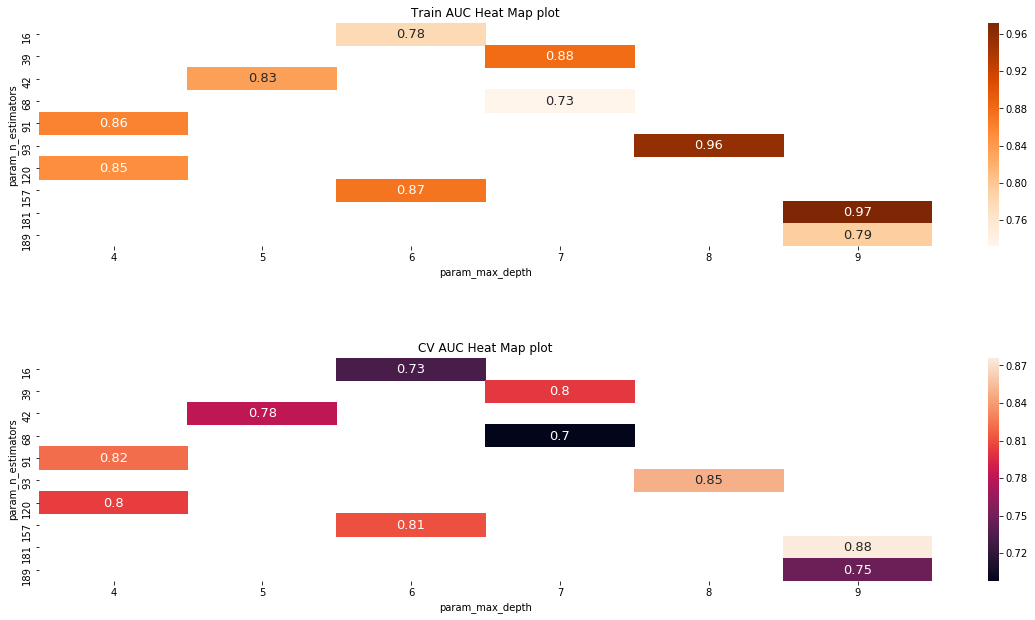

In [0]:
plotTrainVsCV_AUC(search, subplots=(2, 1), figsize=(20, 10), idx='param_n_estimators', cols='param_max_depth')

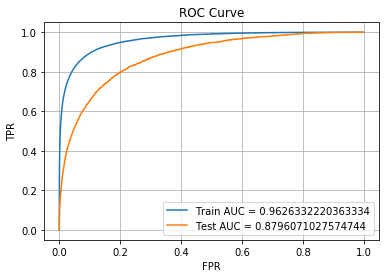

In [0]:
y_train_pred = search.best_estimator_.predict_proba(X_train)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

In [0]:
pt_1.add_row(['', '', '', ''])
pt_1.add_row(['XGBoost', 'Max_depth = 9, n_estimators = 181',\
              np.round(.9626332220363334, 3), np.round(.8796071027574744, 3)])

#### Light GBM

In [0]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "num_leaves": st.randint(100, 200),
    "min_data_in_leaf": st.randint(50, 100), 
    "max_depth": st.randint(5, 10),
    "learning_rate": st.uniform(0.001, 0.1),
    "colsample_bytree": one_to_left,
    # "subsample": one_to_left,
    "reg_lambda": st.uniform(0.0001, 0.1),
    "reg_alpha": st.uniform(0.0001, 0.01),
    "max_bin": st.randint(67, 100),
}

search = RandomizedSearchCV(lgb.LGBMClassifier(objective='binary', n_jobs=-1), params, n_iter=20,\
                            scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True, cv=2, error_score='raise')

In [0]:
# with parallel_backend('multiprocessing'):
search.fit(X_train, y_train, eval_metric='auc')

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   56.3s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  9.2min finished


RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=...
                                        'min_data_in_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3329cf7

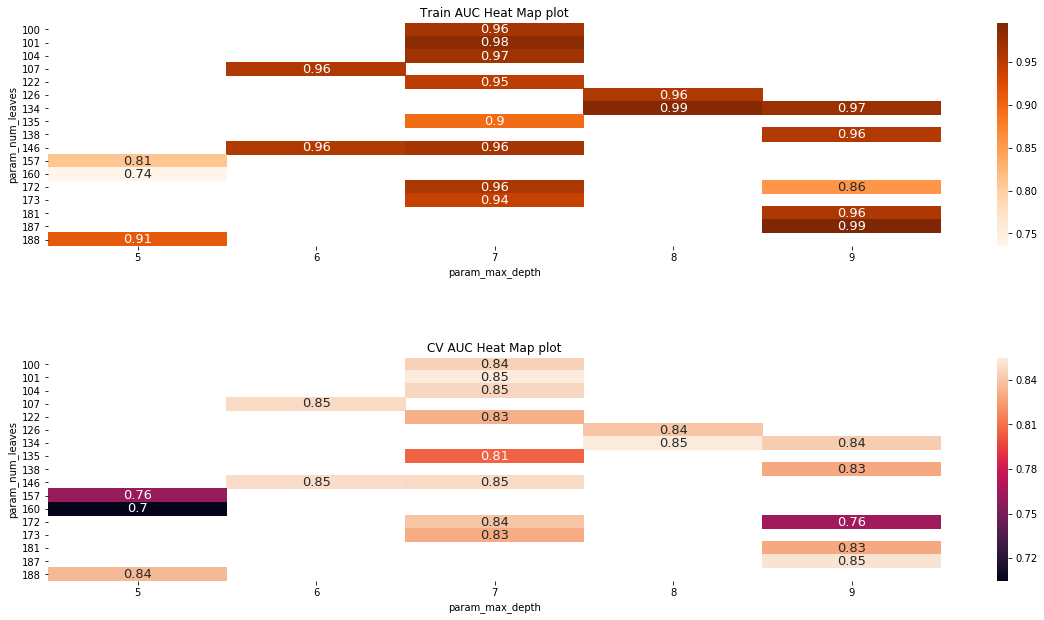

In [0]:
plotTrainVsCV_AUC(search, (2,1), (20, 10), idx='param_num_leaves', cols='param_max_depth')

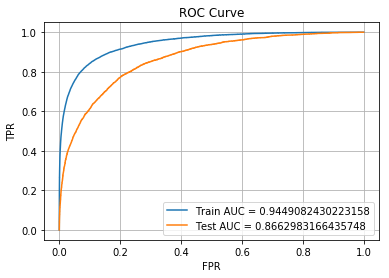

In [0]:
y_train_pred = search.best_estimator_.predict_proba(X_train)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

In [0]:
pt_1.add_row(['', '', '', ''])
pt_1.add_row(['Light GBM', 'Max_depth = 6, num_leaves = 181',\
              np.round(.9449082430223158, 3), np.round(.8662983166435748, 3)])

### New Features

#### Type - 1 | Count Features :

In [0]:
total_vars = X_train.columns.difference(['mean', 'std', 'max', 'min', 'median']).size

X_train_cnt = np.zeros((len(X_train), total_vars * 4))
X_test_cnt = np.zeros((len(X_test), total_vars * 4))

for j in tqdm(range(total_vars)):
    for i in range(1, 4):
        x = np.round(X_train.iloc[:, j], i+1)
        dic = pd.value_counts(x)
        missedValue = dic.idxmax() #np.median(dic.index)
        dic = dic.to_dict()
        X_train_cnt[:, j*4 + i] = pd.Series(x).map(dic)
        X_test_cnt[:, j*4 + i] = pd.Series(np.round(X_test.iloc[:, j], i+1)).map(lambda p: dic.get(p, missedValue))
    
    x = X_train.iloc[:, j]
    dic = pd.value_counts(x)
    missedValue = dic.idxmax() #np.median(dic.index)
    dic = dic.to_dict()
    
    X_train_cnt[:, j*4] = pd.Series(x).map(dic)
    X_test_cnt[:, j*4] = pd.Series(X_test.iloc[:, j]).map(lambda p: dic.get(p, missedValue))

X_train_basic_feats = X_train[['mean', 'std', 'max', 'min', 'median']].copy()
X_test_basic_feats = X_test[['mean', 'std', 'max', 'min', 'median']].copy()

X_train_raw = X_train[X_train.columns.difference(['mean', 'std', 'max', 'min', 'median'])].copy()
X_test_raw = X_test[X_test.columns.difference(['mean', 'std', 'max', 'min', 'median'])].copy()

X_train_new_feats = np.zeros((len(X_train_raw), total_vars * 5))
X_test_new_feats = np.zeros((len(X_test_raw), total_vars * 5))

# raw + count of rounded feature 
old_cols = X_train_raw.columns
new_cols = list()

for idx in tqdm(range(total_vars)):
    X_train_new_feats[:, 5*idx] = X_train_raw.iloc[:, idx]
    new_cols.extend([old_cols[idx], '{}_count'.format(old_cols[idx])])
                    
    X_train_new_feats[:, 5*idx+1:5*idx+5] = X_train_cnt[:, 4*idx:4*idx+4]
    new_cols.extend(['{}_roundedTo_{}'.format(old_cols[idx], rnd) for rnd in range(2, 5)])
    
    X_test_new_feats[:, 5*idx] = X_test_raw.iloc[:, idx]
    X_test_new_feats[:, 5*idx+1:5*idx+5] = X_test_cnt[:, 4*idx:4*idx+4]
                    
X_train_new_feats = pd.DataFrame(X_train_new_feats, columns=new_cols)
X_test_new_feats = pd.DataFrame(X_test_new_feats, columns=new_cols)

del X_train_cnt, X_test_cnt, X_train_raw, X_test_raw; gc.collect()

100%|██████████| 200/200 [00:05<00:00, 36.48it/s]


0

In [0]:
basic_feats_also = str(input('Do you want to use basic features also (y/n) : ')) == 'y'

X_tr = pd.concat([X_train_new_feats.reset_index(drop=True), X_train_basic_feats.reset_index(drop=True)],\
                 axis=1, sort=False) if basic_feats_also else X_train_new_feats
X_te = pd.concat([X_test_new_feats.reset_index(drop=True), X_test_basic_feats.reset_index(drop=True)],\
                 axis=1, sort=False) if basic_feats_also else X_test_new_feats

Do you want to use basic features also (y/n) : n


In [0]:
X_tr.shape, X_te.shape

((160000, 1000), (40000, 1000))

In [0]:
y_train.shape, y_test.shape

((160000,), (40000,))

#### Type - 2 | Rounded features :

In [13]:
X_tr_2 = X_train[X_train.columns.difference(['mean', 'std', 'max', 'min', 'median'])].copy()
X_te_2 = X_test[X_test.columns.difference(['mean', 'std', 'max', 'min', 'median'])].copy() 

for feature in tqdm(X_tr_2.columns):
    X_tr_2[feature+'_r2'] = np.round(X_tr_2[feature], 2)
    X_tr_2[feature+'_r1'] = np.round(X_tr_2[feature], 1)
    
    X_te_2[feature+'_r2'] = np.round(X_te_2[feature], 2)
    X_te_2[feature+'_r1'] = np.round(X_te_2[feature], 1)

100%|██████████| 200/200 [00:02<00:00, 69.28it/s]


In [14]:
basic_feats_also = str(input('Do you want to use basic features also (y/n) : ')) == 'y'

X_tr_2 = pd.concat([X_tr_2.reset_index(drop=True),\
                    X_train[['mean', 'std', 'max', 'min', 'median']].copy().reset_index(drop=True)],\
                 axis=1, sort=False) if basic_feats_also else X_train_new_feats
X_te_2 = pd.concat([X_te_2.reset_index(drop=True),\
                    X_test[['mean', 'std', 'max', 'min', 'median']].copy().reset_index(drop=True)],\
                 axis=1, sort=False) if basic_feats_also else X_test_new_feats

Do you want to use basic features also (y/n) : y


### Modelling [2] - w/ new[, basic] features.

In [0]:
pt_2 = PrettyTable()
pt_2.field_names = ['Model', 'Hyper Parameters', 'Train AUC', 'Test AUC']

#### Logistic Regression :

In [0]:
clf = linear_model.LogisticRegression(penalty='elasticnet', n_jobs=-1, class_weight='balanced', solver='saga', fit_intercept=False)

params = dict(C=(.0001, .001, .01, .1), max_iter=st.randint(800, 1000), l1_ratio=st.uniform(.15, .5))
search = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, verbose=10, return_train_score=True, cv=2, n_iter=20)

In [0]:
with parallel_backend('multiprocessing'):
  search.fit(scaler.fit_transform(X_tr), y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.


[CV] C=0.0001, l1_ratio=0.40540059812874696, max_iter=849 ............
[CV] C=0.0001, l1_ratio=0.40540059812874696, max_iter=849 ............
[CV] C=0.01, l1_ratio=0.28284730554247794, max_iter=902 ..............
[CV] C=0.01, l1_ratio=0.28284730554247794, max_iter=902 ..............
[CV]  C=0.0001, l1_ratio=0.40540059812874696, max_iter=849, score=(train=0.649, test=0.641), total=  45.6s
[CV] C=0.1, l1_ratio=0.6347826726244412, max_iter=841 ................
[CV]  C=0.0001, l1_ratio=0.40540059812874696, max_iter=849, score=(train=0.639, test=0.639), total=  47.8s
[CV] C=0.1, l1_ratio=0.6347826726244412, max_iter=841 ................
[CV]  C=0.01, l1_ratio=0.28284730554247794, max_iter=902, score=(train=0.893, test=0.877), total= 1.3min
[CV] C=0.001, l1_ratio=0.5839910295748246, max_iter=923 ..............
[CV]  C=0.01, l1_ratio=0.28284730554247794, max_iter=902, score=(train=0.891, test=0.879), total= 1.9min
[CV] C=0.001, l1_ratio=0.5839910295748246, max_iter=923 ..............
[CV]  C=

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min


[CV]  C=0.1, l1_ratio=0.6347826726244412, max_iter=841, score=(train=0.893, test=0.876), total= 1.3min
[CV] C=0.0001, l1_ratio=0.5667287045097704, max_iter=900 .............
[CV]  C=0.001, l1_ratio=0.5839910295748246, max_iter=923, score=(train=0.873, test=0.869), total=  56.2s
[CV] C=0.01, l1_ratio=0.45957488288800297, max_iter=943 ..............
[CV]  C=0.0001, l1_ratio=0.5667287045097704, max_iter=900, score=(train=0.500, test=0.500), total=  24.7s
[CV] C=0.01, l1_ratio=0.45957488288800297, max_iter=943 ..............
[CV]  C=0.0001, l1_ratio=0.5667287045097704, max_iter=900, score=(train=0.500, test=0.500), total=  26.5s
[CV] C=0.1, l1_ratio=0.5933255298866175, max_iter=863 ................
[CV]  C=0.001, l1_ratio=0.5839910295748246, max_iter=923, score=(train=0.875, test=0.867), total=  52.3s
[CV] C=0.1, l1_ratio=0.5933255298866175, max_iter=863 ................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min


[CV]  C=0.01, l1_ratio=0.45957488288800297, max_iter=943, score=(train=0.890, test=0.880), total= 1.2min
[CV] C=0.001, l1_ratio=0.2894029134510545, max_iter=802 ..............
[CV]  C=0.01, l1_ratio=0.45957488288800297, max_iter=943, score=(train=0.892, test=0.877), total= 1.2min
[CV] C=0.001, l1_ratio=0.2894029134510545, max_iter=802 ..............
[CV]  C=0.1, l1_ratio=0.5933255298866175, max_iter=863, score=(train=0.892, test=0.878), total= 1.2min
[CV] C=0.1, l1_ratio=0.22196647609466505, max_iter=946 ...............
[CV]  C=0.1, l1_ratio=0.5933255298866175, max_iter=863, score=(train=0.893, test=0.876), total= 1.3min
[CV] C=0.1, l1_ratio=0.22196647609466505, max_iter=946 ...............
[CV]  C=0.001, l1_ratio=0.2894029134510545, max_iter=802, score=(train=0.883, test=0.877), total=  55.2s
[CV] C=0.0001, l1_ratio=0.4202726590010638, max_iter=871 .............
[CV]  C=0.001, l1_ratio=0.2894029134510545, max_iter=802, score=(train=0.885, test=0.875), total=  55.9s
[CV] C=0.0001, l1_r

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.0min


[CV]  C=0.1, l1_ratio=0.22196647609466505, max_iter=946, score=(train=0.892, test=0.878), total= 1.3min
[CV] C=0.001, l1_ratio=0.1545037567823819, max_iter=898 ..............
[CV]  C=0.0001, l1_ratio=0.4202726590010638, max_iter=871, score=(train=0.632, test=0.624), total=  44.0s
[CV] C=0.01, l1_ratio=0.5816246884542369, max_iter=883 ...............
[CV]  C=0.001, l1_ratio=0.1545037567823819, max_iter=898, score=(train=0.887, test=0.879), total=  59.0s
[CV] C=0.01, l1_ratio=0.5816246884542369, max_iter=883 ...............
[CV]  C=0.001, l1_ratio=0.1545037567823819, max_iter=898, score=(train=0.889, test=0.877), total= 1.1min
[CV] C=0.001, l1_ratio=0.3932018575524343, max_iter=921 ..............
[CV]  C=0.01, l1_ratio=0.5816246884542369, max_iter=883, score=(train=0.890, test=0.880), total= 1.1min
[CV] C=0.001, l1_ratio=0.3932018575524343, max_iter=921 ..............
[CV]  C=0.1, l1_ratio=0.22196647609466505, max_iter=946, score=(train=0.893, test=0.876), total= 2.2min
[CV] C=0.1, l1_ra

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.1min


[CV]  C=0.001, l1_ratio=0.3932018575524343, max_iter=921, score=(train=0.882, test=0.873), total=  58.0s
[CV] C=0.001, l1_ratio=0.35302373545693966, max_iter=882 .............
[CV]  C=0.01, l1_ratio=0.5816246884542369, max_iter=883, score=(train=0.892, test=0.877), total= 1.3min
[CV] C=0.001, l1_ratio=0.35302373545693966, max_iter=882 .............
[CV]  C=0.1, l1_ratio=0.45391957123442916, max_iter=983, score=(train=0.892, test=0.878), total= 1.2min
[CV] C=0.0001, l1_ratio=0.5563723898738865, max_iter=974 .............
[CV]  C=0.0001, l1_ratio=0.5563723898738865, max_iter=974, score=(train=0.500, test=0.500), total=  25.7s
[CV] C=0.0001, l1_ratio=0.5563723898738865, max_iter=974 .............
[CV]  C=0.001, l1_ratio=0.35302373545693966, max_iter=882, score=(train=0.881, test=0.876), total=  55.3s
[CV] C=0.0001, l1_ratio=0.5447952733137348, max_iter=862 .............
[CV]  C=0.001, l1_ratio=0.35302373545693966, max_iter=882, score=(train=0.883, test=0.874), total=  57.3s
[CV] C=0.0001,

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  8.8min


[CV]  C=0.0001, l1_ratio=0.5447952733137348, max_iter=862, score=(train=0.570, test=0.564), total=  49.5s
[CV] C=0.01, l1_ratio=0.4964518773723896, max_iter=951 ...............
[CV]  C=0.001, l1_ratio=0.4740555376479476, max_iter=834, score=(train=0.877, test=0.872), total=  54.3s
[CV] C=0.1, l1_ratio=0.5723260976994545, max_iter=901 ................
[CV]  C=0.001, l1_ratio=0.4740555376479476, max_iter=834, score=(train=0.879, test=0.870), total=  55.7s
[CV] C=0.1, l1_ratio=0.5723260976994545, max_iter=901 ................
[CV]  C=0.01, l1_ratio=0.4964518773723896, max_iter=951, score=(train=0.890, test=0.880), total= 1.1min
[CV]  C=0.01, l1_ratio=0.4964518773723896, max_iter=951, score=(train=0.892, test=0.877), total= 1.1min


[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed: 10.3min remaining:   32.5s


[CV]  C=0.1, l1_ratio=0.5723260976994545, max_iter=901, score=(train=0.892, test=0.878), total= 1.1min
[CV]  C=0.1, l1_ratio=0.5723260976994545, max_iter=901, score=(train=0.893, test=0.876), total= 1.1min


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.5min finished


In [0]:
search.best_params_

{'C': 0.01, 'l1_ratio': 0.5816246884542369, 'max_iter': 883}

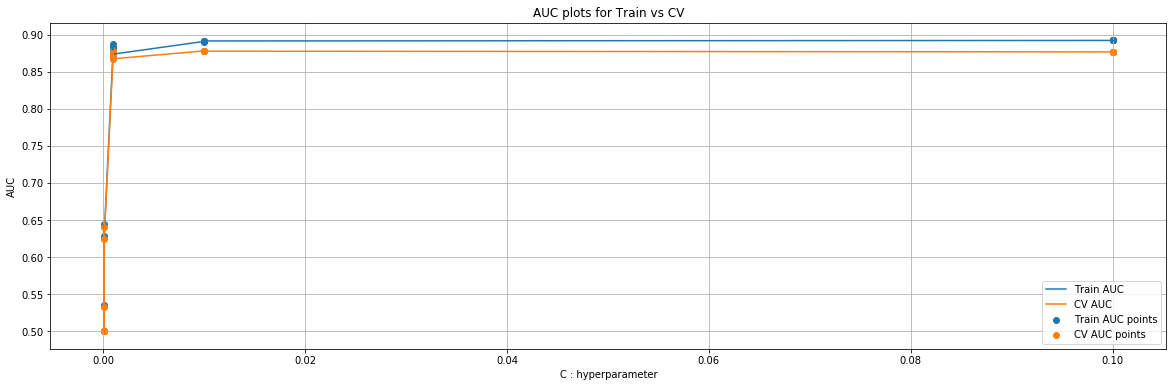

In [0]:
res = pd.DataFrame(search.cv_results_)
idxs = np.argsort(res.param_C.values.astype('float64'))

auc_plot(res.param_C.values.astype('float64')[idxs], res.mean_train_score.values[idxs], res.mean_test_score.values[idxs], 'C')

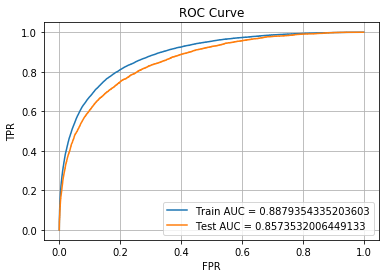

In [0]:
y_train_pred = search.best_estimator_.predict_proba(scaler.transform(X_tr))[:,1]
y_test_pred = search.best_estimator_.predict_proba(scaler.transform(X_te))[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

In [0]:
pt_2.add_row(['Logistic Regression', 'C = 0.01, l1_ratio = 0.5816246884542369, max_iter = 883',\
              np.round(.887993, 3), np.round(.857353, 3)])

#### XGBoost :

In [0]:
# https://github.com/dmlc/xgboost/blob/master/demo/kaggle-higgs/higgs-numpy.py

weight = (X_train.var_76 * float(X_test.shape[0]) / len(y_train))

sum_wpos = sum( weight.iloc[i] for i in range(len(y_train)) if y_train[i] )
sum_wneg = sum( weight.iloc[i] for i in range(len(y_train)) if not y_train[i] )

In [0]:
xgb.XGBClassifier?

In [0]:
# https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html

one_to_left = st.beta(5, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": st.randint(100, 123),
    "max_depth": st.randint(2, 5),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    "reg_lambda": (.001, .01, .1),
    "reg_alpha": (.001, .01, .1),
    "min_child_weight": from_zero_positive,
    "learning_rate": (.01, .1)
}

search = RandomizedSearchCV(xgb.XGBClassifier(max_delta_step=10, eval_metric='auc', objective='binary:logistic',\
                                              n_jobs=-1, scale_pos_weight=sum_wneg/sum_wpos, num_boost_round=100000),\
                            params, scoring='roc_auc', n_jobs=-1, verbose=23, return_train_score=True, cv=2)

In [19]:
with parallel_backend('threading'):
  search.fit(X_tr_2, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] colsample_bytree=0.9795385580301809, gamma=7.48368178462424, learning_rate=0.1, max_depth=3, min_child_weight=26.306065256124405, n_estimators=116, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8693109798363479 [CV] colsample_bytree=0.9795385580301809, gamma=7.48368178462424, learning_rate=0.1, max_depth=3, min_child_weight=26.306065256124405, n_estimators=116, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8693109798363479 [CV] colsample_bytree=0.981991935471296, gamma=3.133728648190235, learning_rate=0.01, max_depth=2, min_child_weight=6.56542037919276, n_estimators=122, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9185191139938026 [CV] colsample_bytree=0.981991935471296, gamma=3.133728648190235, learning_rate=0.01, max_depth=2, min_child_weight=6.56542037919276, n_estimators=122, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9185191139938026 





[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[CV]  colsample_bytree=0.981991935471296, gamma=3.133728648190235, learning_rate=0.01, max_depth=2, min_child_weight=6.56542037919276, n_estimators=122, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9185191139938026, score=(train=0.702, test=0.690), total= 6.4min
[CV] colsample_bytree=0.7306922599120634, gamma=8.954793152617174, learning_rate=0.1, max_depth=3, min_child_weight=86.38868548503523, n_estimators=122, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5839620442647151 


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.5min


[CV]  colsample_bytree=0.981991935471296, gamma=3.133728648190235, learning_rate=0.01, max_depth=2, min_child_weight=6.56542037919276, n_estimators=122, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9185191139938026, score=(train=0.712, test=0.696), total= 6.4min
[CV] colsample_bytree=0.7306922599120634, gamma=8.954793152617174, learning_rate=0.1, max_depth=3, min_child_weight=86.38868548503523, n_estimators=122, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5839620442647151 


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  6.5min


[CV]  colsample_bytree=0.9795385580301809, gamma=7.48368178462424, learning_rate=0.1, max_depth=3, min_child_weight=26.306065256124405, n_estimators=116, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8693109798363479, score=(train=0.885, test=0.840), total= 8.8min
[CV] colsample_bytree=0.97312978438908, gamma=5.242335416132442, learning_rate=0.1, max_depth=2, min_child_weight=104.78643562746936, n_estimators=116, reg_alpha=0.01, reg_lambda=0.001, subsample=0.9904962826855939 


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  8.8min


[CV]  colsample_bytree=0.9795385580301809, gamma=7.48368178462424, learning_rate=0.1, max_depth=3, min_child_weight=26.306065256124405, n_estimators=116, reg_alpha=0.01, reg_lambda=0.01, subsample=0.8693109798363479, score=(train=0.885, test=0.838), total= 8.8min
[CV] colsample_bytree=0.97312978438908, gamma=5.242335416132442, learning_rate=0.1, max_depth=2, min_child_weight=104.78643562746936, n_estimators=116, reg_alpha=0.01, reg_lambda=0.001, subsample=0.9904962826855939 


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  8.9min


[CV]  colsample_bytree=0.7306922599120634, gamma=8.954793152617174, learning_rate=0.1, max_depth=3, min_child_weight=86.38868548503523, n_estimators=122, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5839620442647151, score=(train=0.885, test=0.845), total= 6.6min
[CV] colsample_bytree=0.964207487966292, gamma=0.7612741260974909, learning_rate=0.1, max_depth=3, min_child_weight=81.85692285482902, n_estimators=103, reg_alpha=0.001, reg_lambda=0.001, subsample=0.7881643463534637 

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 13.1min



[CV]  colsample_bytree=0.7306922599120634, gamma=8.954793152617174, learning_rate=0.1, max_depth=3, min_child_weight=86.38868548503523, n_estimators=122, reg_alpha=0.1, reg_lambda=0.001, subsample=0.5839620442647151, score=(train=0.885, test=0.843), total= 6.6min
[CV] colsample_bytree=0.964207487966292, gamma=0.7612741260974909, learning_rate=0.1, max_depth=3, min_child_weight=81.85692285482902, n_estimators=103, reg_alpha=0.001, reg_lambda=0.001, subsample=0.7881643463534637 


[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 13.2min


[CV]  colsample_bytree=0.97312978438908, gamma=5.242335416132442, learning_rate=0.1, max_depth=2, min_child_weight=104.78643562746936, n_estimators=116, reg_alpha=0.01, reg_lambda=0.001, subsample=0.9904962826855939, score=(train=0.851, test=0.825), total= 6.1min
[CV] colsample_bytree=0.7768314957295858, gamma=2.246418634135564, learning_rate=0.1, max_depth=4, min_child_weight=19.924485703424306, n_estimators=105, reg_alpha=0.1, reg_lambda=0.01, subsample=0.7651510127958602 


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 14.9min


[CV]  colsample_bytree=0.97312978438908, gamma=5.242335416132442, learning_rate=0.1, max_depth=2, min_child_weight=104.78643562746936, n_estimators=116, reg_alpha=0.01, reg_lambda=0.001, subsample=0.9904962826855939, score=(train=0.850, test=0.820), total= 6.0min
[CV] colsample_bytree=0.7768314957295858, gamma=2.246418634135564, learning_rate=0.1, max_depth=4, min_child_weight=19.924485703424306, n_estimators=105, reg_alpha=0.1, reg_lambda=0.01, subsample=0.7651510127958602 


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 15.0min


[CV]  colsample_bytree=0.964207487966292, gamma=0.7612741260974909, learning_rate=0.1, max_depth=3, min_child_weight=81.85692285482902, n_estimators=103, reg_alpha=0.001, reg_lambda=0.001, subsample=0.7881643463534637, score=(train=0.878, test=0.837), total= 7.5min
[CV] colsample_bytree=0.8619262389413318, gamma=4.074731259525173, learning_rate=0.01, max_depth=4, min_child_weight=50.30903142680757, n_estimators=117, reg_alpha=0.01, reg_lambda=0.1, subsample=0.9138171108843222 


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 20.7min


[CV]  colsample_bytree=0.964207487966292, gamma=0.7612741260974909, learning_rate=0.1, max_depth=3, min_child_weight=81.85692285482902, n_estimators=103, reg_alpha=0.001, reg_lambda=0.001, subsample=0.7881643463534637, score=(train=0.878, test=0.835), total= 7.5min
[CV] colsample_bytree=0.8619262389413318, gamma=4.074731259525173, learning_rate=0.01, max_depth=4, min_child_weight=50.30903142680757, n_estimators=117, reg_alpha=0.01, reg_lambda=0.1, subsample=0.9138171108843222 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 20.7min


[CV]  colsample_bytree=0.7768314957295858, gamma=2.246418634135564, learning_rate=0.1, max_depth=4, min_child_weight=19.924485703424306, n_estimators=105, reg_alpha=0.1, reg_lambda=0.01, subsample=0.7651510127958602, score=(train=0.912, test=0.845), total= 8.4min
[CV] colsample_bytree=0.6594019736141953, gamma=2.6035533500979504, learning_rate=0.01, max_depth=4, min_child_weight=61.193191400991445, n_estimators=116, reg_alpha=0.001, reg_lambda=0.1, subsample=0.6278599077588631 


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 23.4min


[CV]  colsample_bytree=0.7768314957295858, gamma=2.246418634135564, learning_rate=0.1, max_depth=4, min_child_weight=19.924485703424306, n_estimators=105, reg_alpha=0.1, reg_lambda=0.01, subsample=0.7651510127958602, score=(train=0.911, test=0.843), total= 8.4min
[CV] colsample_bytree=0.6594019736141953, gamma=2.6035533500979504, learning_rate=0.01, max_depth=4, min_child_weight=61.193191400991445, n_estimators=116, reg_alpha=0.001, reg_lambda=0.1, subsample=0.6278599077588631 


[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 23.4min


[CV]  colsample_bytree=0.6594019736141953, gamma=2.6035533500979504, learning_rate=0.01, max_depth=4, min_child_weight=61.193191400991445, n_estimators=116, reg_alpha=0.001, reg_lambda=0.1, subsample=0.6278599077588631, score=(train=0.773, test=0.743), total= 7.6min
[CV] colsample_bytree=0.9074312279518009, gamma=8.441913379007856, learning_rate=0.01, max_depth=2, min_child_weight=22.495303701236598, n_estimators=118, reg_alpha=0.01, reg_lambda=0.01, subsample=0.955217118357863 


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 31.1min


[CV]  colsample_bytree=0.6594019736141953, gamma=2.6035533500979504, learning_rate=0.01, max_depth=4, min_child_weight=61.193191400991445, n_estimators=116, reg_alpha=0.001, reg_lambda=0.1, subsample=0.6278599077588631, score=(train=0.778, test=0.744), total= 7.7min
[CV] colsample_bytree=0.9074312279518009, gamma=8.441913379007856, learning_rate=0.01, max_depth=2, min_child_weight=22.495303701236598, n_estimators=118, reg_alpha=0.01, reg_lambda=0.01, subsample=0.955217118357863 


[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed: 31.2min remaining: 13.4min


[CV]  colsample_bytree=0.8619262389413318, gamma=4.074731259525173, learning_rate=0.01, max_depth=4, min_child_weight=50.30903142680757, n_estimators=117, reg_alpha=0.01, reg_lambda=0.1, subsample=0.9138171108843222, score=(train=0.769, test=0.737), total=10.5min
[CV] colsample_bytree=0.8705828787827952, gamma=6.169139480861725, learning_rate=0.01, max_depth=4, min_child_weight=74.85042440808952, n_estimators=112, reg_alpha=0.1, reg_lambda=0.01, subsample=0.48538140978171307 


[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed: 31.3min remaining: 10.4min


[CV]  colsample_bytree=0.8619262389413318, gamma=4.074731259525173, learning_rate=0.01, max_depth=4, min_child_weight=50.30903142680757, n_estimators=117, reg_alpha=0.01, reg_lambda=0.1, subsample=0.9138171108843222, score=(train=0.774, test=0.737), total=10.5min
[CV] colsample_bytree=0.8705828787827952, gamma=6.169139480861725, learning_rate=0.01, max_depth=4, min_child_weight=74.85042440808952, n_estimators=112, reg_alpha=0.1, reg_lambda=0.01, subsample=0.48538140978171307 


[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed: 31.3min remaining:  7.8min


[CV]  colsample_bytree=0.9074312279518009, gamma=8.441913379007856, learning_rate=0.01, max_depth=2, min_child_weight=22.495303701236598, n_estimators=118, reg_alpha=0.01, reg_lambda=0.01, subsample=0.955217118357863, score=(train=0.700, test=0.689), total= 5.8min


[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed: 36.9min remaining:  6.5min


[CV]  colsample_bytree=0.9074312279518009, gamma=8.441913379007856, learning_rate=0.01, max_depth=2, min_child_weight=22.495303701236598, n_estimators=118, reg_alpha=0.01, reg_lambda=0.01, subsample=0.955217118357863, score=(train=0.708, test=0.692), total= 5.8min


[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 37.0min remaining:  4.1min


[CV]  colsample_bytree=0.8705828787827952, gamma=6.169139480861725, learning_rate=0.01, max_depth=4, min_child_weight=74.85042440808952, n_estimators=112, reg_alpha=0.1, reg_lambda=0.01, subsample=0.48538140978171307, score=(train=0.776, test=0.748), total= 7.3min
[CV]  colsample_bytree=0.8705828787827952, gamma=6.169139480861725, learning_rate=0.01, max_depth=4, min_child_weight=74.85042440808952, n_estimators=112, reg_alpha=0.1, reg_lambda=0.01, subsample=0.48538140978171307, score=(train=0.779, test=0.745), total= 7.3min


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 38.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 38.6min finished


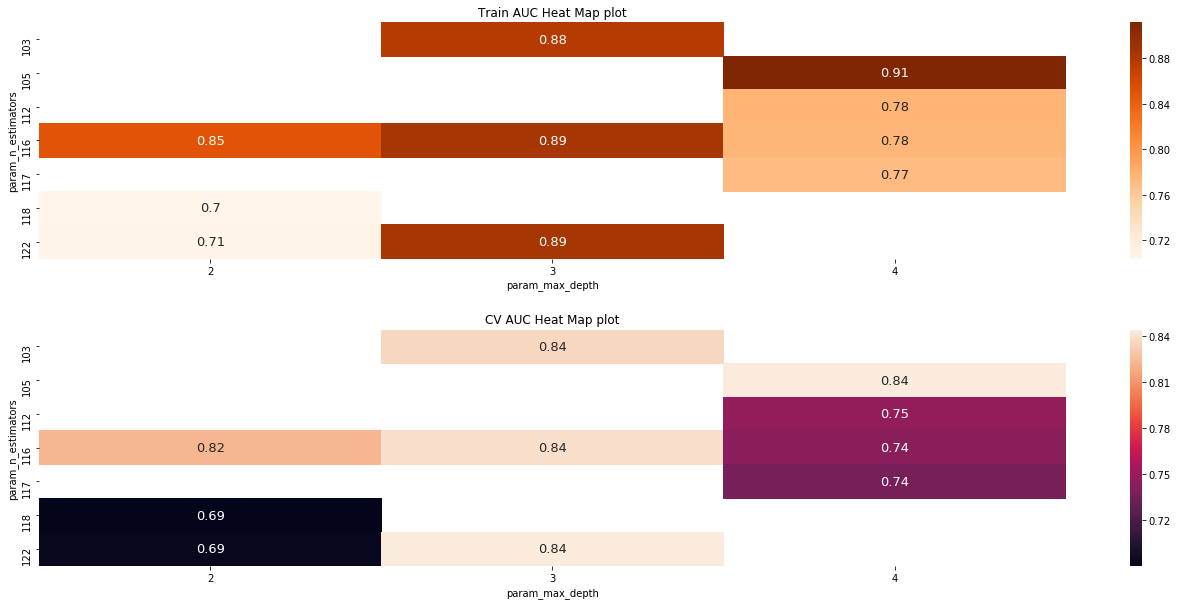

In [20]:
plotTrainVsCV_AUC(search, subplots=(2, 1), figsize=(23, 10), idx='param_n_estimators', cols='param_max_depth')

In [23]:
search.best_params

{'colsample_bytree': 0.7306922599120634,
 'gamma': 8.954793152617174,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 86.38868548503523,
 'n_estimators': 122,
 'reg_alpha': 0.1,
 'reg_lambda': 0.001,
 'subsample': 0.5839620442647151}

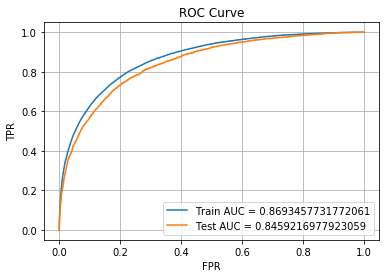

In [21]:
y_train_pred = search.best_estimator_.predict_proba(X_tr_2)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_te_2)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

In [0]:
pt_2.add_row(['', '', '', ''])
pt_2.add_row(['XGBoost', 'Max_depth = 3, n_estimators = 122', np.round(.86934577, 3), np.round(.84592169, 3)])

The maximum value of Train tpr*(1-fpr) is 0.6195002830787604 for threshold 0.546999990940094 

The maximum value of Test tpr*(1-fpr) is 0.5892037865148962 for threshold 0.5440000295639038 



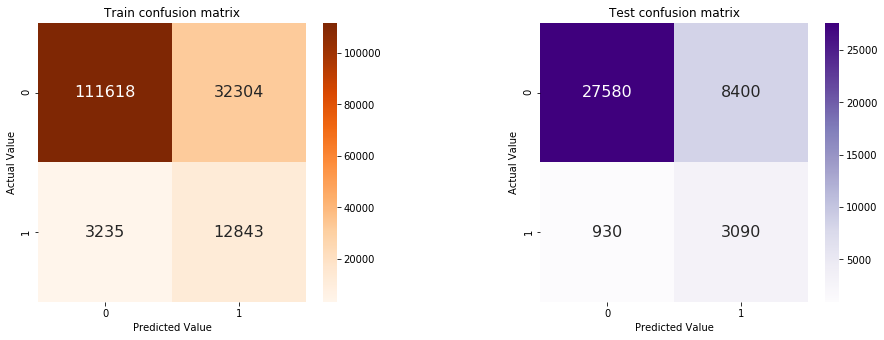

In [22]:
printConfusionMatrix(y_train, y_test, y_train_pred, y_test_pred, tr_thresholds, te_thresholds, train_fpr, train_tpr, test_fpr, test_tpr)

#### Light GBM

In [0]:
# Hyperparameter tuning in light gbm : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
params = {  
    "num_leaves": st.randint(30, 80),
    "min_data_in_leaf": st.randint(80, 100), 
    "max_depth": st.randint(2, 7),
    "learning_rate": (.01, .1),
    "reg_lambda": (.001, .01, .1),
    "reg_alpha": (.001, .01, .1),
    "max_bin": st.randint(67, 100),
    "min_gain_to_split": st.uniform(0, 10)
}

search = RandomizedSearchCV(lgb.LGBMClassifier(objective='binary', n_jobs=-1, min_sum_hessian_in_leaf=10., bagging_freq=5, bagging_fraction=.4, boost_from_average=False,\
                                               feature_fraction=.05, num_round=100000),\
                            params, n_iter=10, scoring='roc_auc', verbose=10, return_train_score=True, cv=2, error_score='raise')

In [26]:
# with parallel_backend('multiprocessing'):
search.fit(X_tr_2, y_train, eval_metric='auc')

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=80, min_gain_to_split=5.756727905110919, num_leaves=45, reg_alpha=0.1, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=80, min_gain_to_split=5.756727905110919, num_leaves=45, reg_alpha=0.1, reg_lambda=0.01, score=(train=0.946, test=0.890), total= 3.6min
[CV] learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=80, min_gain_to_split=5.756727905110919, num_leaves=45, reg_alpha=0.1, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=80, min_gain_to_split=5.756727905110919, num_leaves=45, reg_alpha=0.1, reg_lambda=0.01, score=(train=0.949, test=0.888), total= 3.6min
[CV] learning_rate=0.1, max_bin=79, max_depth=6, min_data_in_leaf=91, min_gain_to_split=2.15719108068663, num_leaves=43, reg_alpha=0.01, reg_lambda=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.3min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=79, max_depth=6, min_data_in_leaf=91, min_gain_to_split=2.15719108068663, num_leaves=43, reg_alpha=0.01, reg_lambda=0.001, score=(train=0.999, test=0.873), total= 4.3min
[CV] learning_rate=0.1, max_bin=79, max_depth=6, min_data_in_leaf=91, min_gain_to_split=2.15719108068663, num_leaves=43, reg_alpha=0.01, reg_lambda=0.001 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.9min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=79, max_depth=6, min_data_in_leaf=91, min_gain_to_split=2.15719108068663, num_leaves=43, reg_alpha=0.01, reg_lambda=0.001, score=(train=0.999, test=0.872), total= 4.3min
[CV] learning_rate=0.1, max_bin=81, max_depth=6, min_data_in_leaf=86, min_gain_to_split=6.340819585601512, num_leaves=62, reg_alpha=0.001, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=81, max_depth=6, min_data_in_leaf=86, min_gain_to_split=6.340819585601512, num_leaves=62, reg_alpha=0.001, reg_lambda=0.01, score=(train=0.942, test=0.891), total= 3.5min
[CV] learning_rate=0.1, max_bin=81, max_depth=6, min_data_in_leaf=86, min_gain_to_split=6.340819585601512, num_leaves=62, reg_alpha=0.001, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.1min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=81, max_depth=6, min_data_in_leaf=86, min_gain_to_split=6.340819585601512, num_leaves=62, reg_alpha=0.001, reg_lambda=0.01, score=(train=0.944, test=0.890), total= 3.5min
[CV] learning_rate=0.01, max_bin=96, max_depth=2, min_data_in_leaf=88, min_gain_to_split=4.431550819941017, num_leaves=73, reg_alpha=0.001, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 23.7min remaining:    0.0s


[CV]  learning_rate=0.01, max_bin=96, max_depth=2, min_data_in_leaf=88, min_gain_to_split=4.431550819941017, num_leaves=73, reg_alpha=0.001, reg_lambda=0.01, score=(train=0.964, test=0.891), total=10.0min
[CV] learning_rate=0.01, max_bin=96, max_depth=2, min_data_in_leaf=88, min_gain_to_split=4.431550819941017, num_leaves=73, reg_alpha=0.001, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 35.7min remaining:    0.0s


[CV]  learning_rate=0.01, max_bin=96, max_depth=2, min_data_in_leaf=88, min_gain_to_split=4.431550819941017, num_leaves=73, reg_alpha=0.001, reg_lambda=0.01, score=(train=0.965, test=0.888), total= 9.6min
[CV] learning_rate=0.1, max_bin=96, max_depth=6, min_data_in_leaf=89, min_gain_to_split=2.1284522761940607, num_leaves=31, reg_alpha=0.001, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 47.5min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=96, max_depth=6, min_data_in_leaf=89, min_gain_to_split=2.1284522761940607, num_leaves=31, reg_alpha=0.001, reg_lambda=0.01, score=(train=0.999, test=0.874), total= 4.1min
[CV] learning_rate=0.1, max_bin=96, max_depth=6, min_data_in_leaf=89, min_gain_to_split=2.1284522761940607, num_leaves=31, reg_alpha=0.001, reg_lambda=0.01 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 51.8min remaining:    0.0s


[CV]  learning_rate=0.1, max_bin=96, max_depth=6, min_data_in_leaf=89, min_gain_to_split=2.1284522761940607, num_leaves=31, reg_alpha=0.001, reg_lambda=0.01, score=(train=0.999, test=0.872), total= 4.4min
[CV] learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=84, min_gain_to_split=6.486166274120549, num_leaves=57, reg_alpha=0.1, reg_lambda=0.01 
[CV]  learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=84, min_gain_to_split=6.486166274120549, num_leaves=57, reg_alpha=0.1, reg_lambda=0.01, score=(train=0.939, test=0.891), total= 3.5min
[CV] learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=84, min_gain_to_split=6.486166274120549, num_leaves=57, reg_alpha=0.1, reg_lambda=0.01 
[CV]  learning_rate=0.1, max_bin=79, max_depth=5, min_data_in_leaf=84, min_gain_to_split=6.486166274120549, num_leaves=57, reg_alpha=0.1, reg_lambda=0.01, score=(train=0.940, test=0.890), total= 3.5min
[CV] learning_rate=0.1, max_bin=96, max_depth=2, min_data_in_leaf=97, min_gain_to_s

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 148.5min finished


RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=LGBMClassifier(bagging_fraction=0.4,
                                            bagging_freq=5,
                                            boost_from_average=False,
                                            boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            feature_fraction=0.05,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            min_sum_hessian_in_l...
                                        'min_data_in_leaf': <scipy.stats._distn_infr

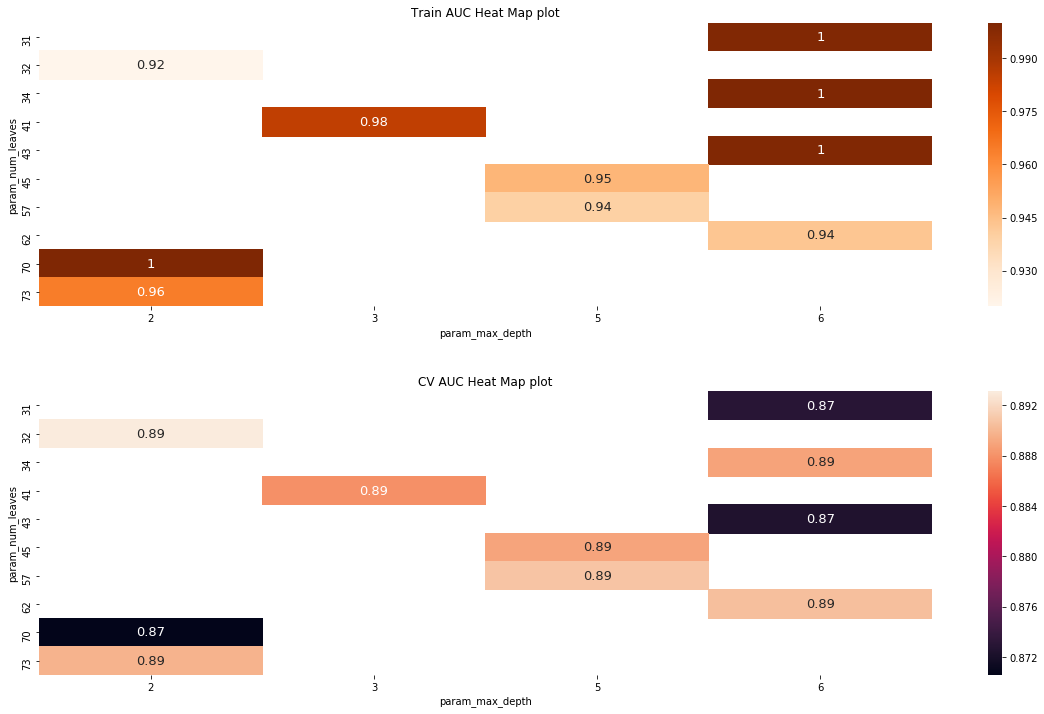

In [27]:
plotTrainVsCV_AUC(search, (2,1), (20, 12), idx='param_num_leaves', cols='param_max_depth')

In [30]:
search.best_params_

{'learning_rate': 0.1,
 'max_bin': 96,
 'max_depth': 2,
 'min_data_in_leaf': 97,
 'min_gain_to_split': 9.293773454804837,
 'num_leaves': 32,
 'reg_alpha': 0.001,
 'reg_lambda': 0.01}

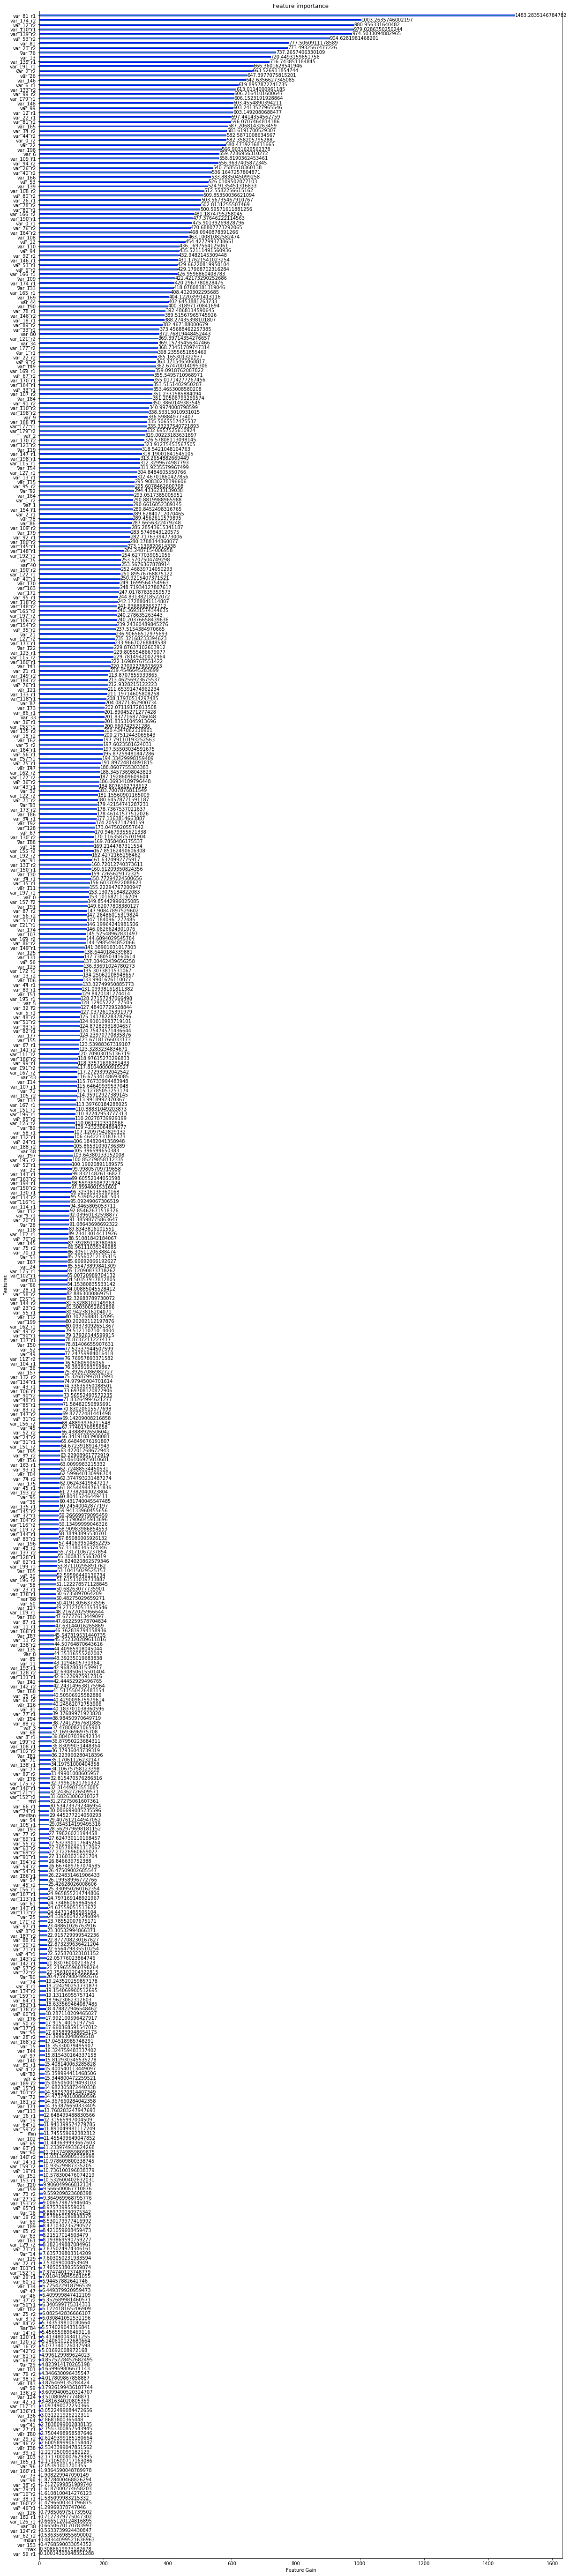

In [62]:
plt.figure(figsize=(20, 100))
lgb.plot_importance(search.best_estimator_, plt.gca(), grid=False, height=.3, edgecolor='blue',\
                    xlabel='Feature Gain', importance_type='gain')
plt.show()

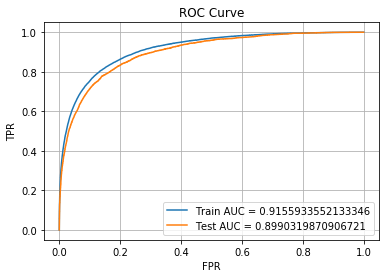

In [28]:
y_train_pred = search.best_estimator_.predict_proba(X_tr_2)[:,1]
y_test_pred = search.best_estimator_.predict_proba(X_te_2)[:,1]

train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = metrics.roc_curve(y_test, y_test_pred)

roc_plot(train_fpr, train_tpr, test_fpr, test_tpr)

In [0]:
pt_2.add_row(['', '', '', ''])
pt_2.add_row(['Light GBM', 'Max_depth = 2, num_leaves = 32', np.round(.9155933, 2), np.round(.89903198, 2)])

The maximum value of Train tpr*(1-fpr) is 0.69762117902598 for threshold 0.116 

The maximum value of Test tpr*(1-fpr) is 0.6692384381593975 for threshold 0.128 



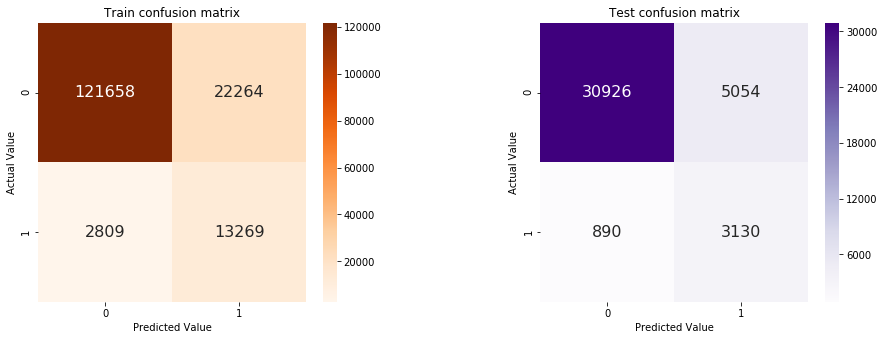

In [31]:
printConfusionMatrix(y_train, y_test, y_train_pred, y_test_pred, tr_thresholds, te_thresholds, train_fpr, train_tpr, test_fpr, test_tpr)

### Comparision of Models :

In [80]:
print('Modelling With the basic features (mean, std, median, min, max) :')
print(pt_1)

Modelling With the basic features (mean, std, median, min, max) :
+---------------------+-----------------------------------+-----------+----------+
|        Model        |          Hyper Parameters         | Train AUC | Test AUC |
+---------------------+-----------------------------------+-----------+----------+
| Logistic Regression |            alpha = 0.01           |   0.859   |  0.857   |
|                     |                                   |           |          |
|    Random Forest    | Max_depth = 8, n_estimators = 100 |   0.898   |  0.807   |
|                     |                                   |           |          |
|       XGBoost       | Max_depth = 9, n_estimators = 181 |   0.963   |   0.88   |
|                     |                                   |           |          |
|      Light GBM      |  Max_depth = 6, num_leaves = 181  |   0.945   |  0.866   |
+---------------------+-----------------------------------+-----------+----------+


In [78]:
print('Modelling With the new features(rounding floats) :')
print(pt_2)

Modelling With the new features(rounding floats) :
+---------------------+---------------------------------------------------------+-----------+----------+
|        Model        |                     Hyper Parameters                    | Train AUC | Test AUC |
+---------------------+---------------------------------------------------------+-----------+----------+
| Logistic Regression | C = 0.01, l1_ratio = 0.5816246884542369, max_iter = 883 |   0.888   |  0.857   |
|                     |                                                         |           |          |
|       XGBoost       |            Max_depth = 3, n_estimators = 122            |   0.869   |  0.846   |
|                     |                                                         |           |          |
|      Light GBM      |              Max_depth = 2, num_leaves = 32             |    0.92   |   0.9    |
+---------------------+---------------------------------------------------------+-----------+----------+


### References :

[1] https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89034#latest-548982

[2] https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003#latest-638601

[3] https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/88939#latest-637010

Light GBM :

[1] https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/

[2] https://lightgbm.readthedocs.io/en/latest/Python-API.html#

[3] https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

[4] https://www.kaggle.com/roydatascience/eda-pca-simple-lgbm-on-kfold-technique

### Steps followed :

1. Collected the data from the kaggle website of the competition Santander customer transaction prediction (classification) dataset. The performance metric used for the classification task is **Area Under ROC**. 
2. Performed the data cleaning, processing checking for unknown values, filling the missing values. But found that dataset is complete without any missing values, that made the preprocessing simple.  
3. Then performed the high level analysis of the dataset like,
  * No. of Datapoints,
  * No. of unique class labels and
  * No. of datapoints per unique class label.
4. Found that the dataset is highly imbalanced with no. of datapoints per class,
  * **Class - 1 (Customers who made txn) : 10%**
  * **Class - 0 (Customers who didn't made txn) : 90%**
5. Performed the EDA on the raw features associated with the dataset and found that features are independent of each other. Written some of my observations inline in the EDA.
6. Applied the dimensionality reduction using the PCA to 2 dimnesions and plotted the same. It's hard in separating the classes using linear models as both were completely overlapping.
7. Then I've added the basic features such as mean, standard deviaiton, median, minimum, maximum of 200 numerical features per data point.
8. Made the train and test split of ratio 80 : 20. Used the train data with the basic features for modelling - I.
9. The basic features gave a reasonable **AUROC** of around **0.85** using the Logistic Regression, Random Forest, XGBoost and Light GBM with hyperparameter tuning. Performed hyperparameter tuning for all the models using RandomizedSearch Cross-Validaiton.
10. Referrring to some of the kaggle discussions I've came across and learnt a new boosting algorithm **[Light Gradient boosted Machines(LGBM)](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)** which does splitting leaf-wise instead of depth-wise and gave better predictions than XGBoost.
11. Now I wanted to increase **AUROC** a bit further and gone through some of the kaggle discussions that I referred above. Added some of the count and rounding features for each raw feature as per the discussions.
12. Did the modelling - II with these new count, round features and performed the hyperparameter tuning with previous LR, XGBoost, LGBM.
13. The overfitting problem seems to be reduced for all the models with the new count, rounf features. 
13. LGBM seems to be outperform the other models without overfitting to the training data with the new count, round features which gave an **AUROC** of,
  * `Train data` -> `0.92`.
  * `Test data` -> `0.9`.
14. plotted the feature importance for the LGBM and found that the round features contributed most at each split.
15. Finally compared the all the models for basic and the round features in a table with their train and test **AUROC** and hyperparameters.